# PROJEKT ZALICZENIOWY
### Marcin Brożek, GR II Katowice

# TEMAT: 
## Zbudowanie karty scoringowej dla klientów na moment decyzji kredytowej (w momencie złożenia wniosku aplikacyjnego)


# CEL:

Celem projektu jest zbudowanie modelu `klasyfikacji (binarnej)` do podjęcia decyzji, czy należy udzielić kredytu na moment wniosku aplikacyjnego. Czyli innymi słowy taki model powinien przewidywać klientów, którzy nie spłacą swojego zobowiązania, na podstawie danych z wniosku kredytowego. 

# DANE:

Dane zostały zebrane na moment wniosku aplikacyjnego (wyjątkiem stanowi pole `DEFAULT_FLAG`, które wskazuje którzy klienci nie wykonali zobowiązania w ciągu najbliższych 12 miesięcy od udzielenia kredytu).
Wzięto pod uwagę prawie 80 000 wniosków, za lata 2014-2017, a średnia wartość niewykonania zobowiązania wynosi 4,2%.

Brane są pod uwagę jedynie kredyty udzielone (problem/potrzeba analizy typu Reject Inference, czyli co z kredytami, które poprzedni model odrzucił, nie występuje w tym zadaniu).

Niektórzy klienci mogli wziąć kredyt więcej razy. Każdy z nich jest osobnym wnioskiem kredytowym.

# ŹRÓDŁO:

Zadanie oraz dane zostały zaczerpnięte z `Lion’s Den ING Modeling Challenge 2018`

# OPIS PROJEKTU:

Temat niniejszego projektu jest analogiczny do tematu nr 2 w ramach projektów zaliczeniowych. Dlatego też spełnione zostaną wszystkie wymogi przypisane do tego zagadnienia.

Ponadto analiza zostanie poszerzona o pewne elementy `wykraczające poza zakres zajęć`, w tym m.in.:
* testowanie bardziej złożonych podejść do danych kategorycznych (WOE)
* nietrywialne podejście do missingów (bazowanie na przyczynie braków danych)
* analizy outliers
* testowanie różnych rodzajów selekcji zmiennych (metody eksperckie, rekurencyjne i jednoczynnikowe)
* porównanie metod radzenia sobie z niezbalansowanymi klasami 
* stworzenie własnej metryki do oceny modelu i optymalizacji hiperparametrów


Projekt ten ma również na celu porównanie różnych metod klasyfikacji.

# SPIS TREŚCI:
* ### [ROZDZIAŁ 1 - IMPORT BIBLIOTEK](#rozdz1)
* ### [ROZDZIAŁ 2 - WCZYTANIE DANYCH ORAZ OPIS ZMIENNYCH](#rozdz2)
* ### [ROZDZIAŁ 3 - EKSPLORACJA DANYCH](#rozdz3)
    * ##### [ROZDZIAŁ 3.1 - Przegląd danych pod względem merytorczynym](#rozdz3.1)
    * ##### [ROZDZIAŁ 3.2 - Analiza danych kategorycznych](#rozdz3.2)
    * ##### [ROZDZIAŁ 3.3 - Analiza danych numerycznych - analiza outliers](#rozdz3.3)
    * ##### [ROZDZIAŁ 3.4 - Kwestie braków danych](#rozdz3.4)
    * ##### [ROZDZIAŁ 3.5 - Pozostałe analizy](#rozdz3.5)
* ### [ROZDZIAŁ 4 - CZYSZCZENIE DANYCH](#rozdz4)
    * ##### [ROZDZIAŁ 4.1 - Transformacja danych](#rozdz4.1)
    * ##### [ROZDZIAŁ 4.2 - Dodanie nowych zmiennych](#rozdz4.2)
    * ##### [ROZDZIAŁ 4.3 - Przygotowanie zbiorów treningowych i uczących](#rozdz4.3)
* ### [ROZDZIAŁ 5 - WYBÓR KLASYFIKATORÓW I OCENA MODELU](#rozdz5)
* ### [ROZDZIAŁ 6 - WSTĘPNE MODELOWANIE](#rozdz6)
* ### [ROZDZIAŁ 7 - OPTYMALIZACJA HIPERPARAMETRÓW](#rozdz7)
* ### [ROZDZIAŁ 8 - SELEKCJA ZMIENNYCH](#rozdz8)
* ### [ROZDZIAŁ 9 - PROBLEM NIEZBALANSOWANEJ PRÓBY](#rozdz9)
* ### [ROZDZIAŁ 10 - PODSUMOWANIE](#rozdz10)

## ROZDZIAŁ 1 - IMPORT BIBLIOTEK  <a class="anchor" id="#rozdz1"></a>

In [1]:
#Podstawowe biblioteki użyte do eksploracji danych
import pandas as pd
import numpy  as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Biblioteki związane z transformacją danych i przygotowanie próbki treningowej i testowej
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

#Biblioteki zawierające gotowe implementacje modeli
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

#Biblioteki zawierające metryki oraz metody selekcji zmiennych
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report,make_scorer,roc_curve
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, f_classif, chi2

In [2]:
#Wszystkie ostrzeżenia zostały przeanalizowane przy pierwszym przebiegu.
#Mając na celu przejrzystość ostatecznej wersji ignorujemy ostrzeżenia
import warnings
warnings.filterwarnings('ignore')


## ROZDZIAŁ 2 - WCZYTANIE DANYCH ORAZ OPIS ZMIENNYCH <a class="anchor" id="#rozdz2"></a>

### Wczytanie danych

Projekt zaczniemy standardowo od wczytania danych. Do tego celu użyjemy bliblioteki pandas.

In [3]:
LionsDen = pd.read_csv('LionsDen.csv', delimiter =';', decimal= ',')

Zanim przejdziemy do eksploracji danych, przyjrzyjmy się opisowi danych zawartym w excelu `"Variable description.xlsx"`

In [4]:
#W zależności od ustawień, możliwe, że trzeba zmienić ilość pokazywanych znaków w kolumnie, by pojawił się cały opis:
pd.set_option('display.max_colwidth',1000)
#a w przyszłości wszystkie kolumny:
pd.set_option('display.max_columns',50)
opis_danych = pd.read_excel(r'Variable description.xlsx', sheet_name="Lion'sDen") 
opis_danych[['NAME','OPIS']]

,NAME,OPIS
0,CUSTOMER_ID,Identyfikator klienta
1,APPLICATION_ID,Identyfikator aplikacji
2,DEFAULT_FLAG,"Flaga defaultu, w której wartość 1 oznacza, że klient w ciągu pierwszych 12 miesięcy przestał spłacać kredyt o który aplikował, a wartość 0, że klient spłacał regularnie swoje zobowiązanie"
3,APPLICATION_DATE,Data złożenia aplikacji
4,APPLICATION_HOUR,Godzina złożenia aplikacji (7-24 lub 1-6)
5,APPLICATION_WEEKDAY,Dzień tygodnia złożenia aplikacji
6,APPLICATION_MONTH,Miesiąc złożenia aplikacji
7,APPLICATION_YEAR,Rok złożenia aplikacji
8,PRODUCT_GROUP,"Aplikacja dotyczy produktu z grupy produktowej (CASH LOAN, OVERDRAFT, CREDIT CARD)"
9,LOAN_PERIOD,Okres kredytowania (0 oznacza aplikację o produkt z limitem: CREDIT CARD lub OVERDRAFT)


Pierwsze kroki z danymi zaczniemy od podstawowych informacji, z jakimi typami danych tak naprawdę mamy do czynienia.

In [5]:
LionsDen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79155 entries, 0 to 79154
Data columns (total 50 columns):
CUSTOMER_ID                      79155 non-null int64
APPLICATION_ID                   79155 non-null float64
DEFAULT_FLAG                     79155 non-null int64
APPLICATION_DATE                 79155 non-null object
APPLICATION_HOUR                 79155 non-null object
APPLICATION_WEEKDAY              79155 non-null int64
APPLICATION_MONTH                79155 non-null int64
APPLICATION_YEAR                 79155 non-null int64
PRODUCT_GROUP                    79155 non-null object
LOAN_PERIOD                      79155 non-null int64
CREDIT_AMOUNT                    79155 non-null int64
CUSTOMER_TYPE                    79155 non-null object
COOP_PERIOD                      79155 non-null int64
CREDIT_COOP_PERIOD               79155 non-null int64
AGE                              79155 non-null int64
AGE_BANDS                        79155 non-null object
EDUCATION           

Powyższe możemy podsumować przy użyciu prostej pętli.

In [6]:
podsumowanie_formatow=dict()

for kolumna in LionsDen.columns:
    if LionsDen[kolumna].dtype in podsumowanie_formatow.keys():
        podsumowanie_formatow[LionsDen[kolumna].dtype]=podsumowanie_formatow[LionsDen[kolumna].dtype]+1
    else:
        podsumowanie_formatow[LionsDen[kolumna].dtype]=1
print(podsumowanie_formatow)

{dtype('int64'): 15, dtype('float64'): 17, dtype('O'): 18}


Innymi słowy mamy do czynienia z 50 kolumnami, w tym jest jedna zmienna celu (`"DEFAULT_FLAG"`), a wśród 49 cech wyróżniamy 14 kolumn w formacie liczb całkowitym (15 z zmienną celu), 17 zmiennoprzecinkowych oraz 18 tekstowych. Łatwo można zauważyć, że ważnym elementem może okazać się zaadresowanie jak wydobyć dane z zmiennych kategorycznych.

## ROZDZIAŁ 3 - EKSPLORACJA DANYCH  <a class="anchor" id="#rozdz3"></a>

W tym rozdziale przyjrzymy się bliżej cechom jakie mamy do dyspozycji. Trochę inne podejście będzie w stosunku do cech kategorycznych, a inne do wartości liczbowych. Stąd też rozbicie na poszczególne podrozdziały. Jednak zaczniemy przede wszystkim od szczegółowego przyjrzenia się, czy dane mają jakikolwiek sens biznesowy. W pierwszej kolejności wykluczymy dane, które nie mają żadnego uzasadnienia biznesowego. Pamiętajmy, że model musi być zgodny również z wiedza ekspercką i intuicją biznesową. Bez tego może nie być akceptacji na stosowanie takiego modelu na produkcji.

### ROZDZIAŁ 3.1 - Przegląd danych pod względem merytorczynym  <a class="anchor" id="#rozdz3.1"></a>

###### `CUSTOMER_ID` -  Identyfikator klienta
Jeden klient może ubiegać się o kredyt więcej niż tylko raz. Każdy wniosek to osobna obserwacja. Skoro to ten sam klient to obserwacje te powinny być ze sobą związane. Za pomocą identyfikatora klienta można postarać się połączyć wnioski, również w celu na przykład weryfikacji poprawności danych (czy aplikując w bardzo niewielkim odstępie czasowym klient nie podaje sprzecznych informacji na temat wykształcenia, dochodów i kosztów). Załóżmy jednak, że kwestie poprawności danych oraz fraudów (świadomego wyłudzenia) nie są tematem niniejszego projektu.

By wiedzieć o jakiej skali piszemy, więcej informacji można znaleźć poniżej.

In [7]:
len_uniq_cust=len(LionsDen.CUSTOMER_ID.unique())
len_cust= len(LionsDen.CUSTOMER_ID)

print(f"Ilość nie powtarzających się danych to {len_uniq_cust}")
print(f"Ilość wszystkich rekordów to {len_cust}")
print(f"Ilość duplikatów to {len_cust-len_uniq_cust}")
print(f"Wartości nie powtarzające stanowią {round(len_uniq_cust/len_cust*100,2)}% wszystkich wniosków")

Ilość nie powtarzających się danych to 47179
Ilość wszystkich rekordów to 79155
Ilość duplikatów to 31976
Wartości nie powtarzające stanowią 59.6% wszystkich wniosków


Moglibyśmy również oczyścić dane i każdego klienta wziąć pod uwagę tylko raz (np. najnowszy wniosek), ale pamiętajmy, że ograniczyłoby to nasz zbiór oraz pozbylibyśmy się wielu cennych obserwacji. W tym przypadku stracilibyśmy informację o ponad 31 tys. wniosków co stanowi ponad 40% wszystkich obserwacji. Podsumowując powyższe, na potrzeby niniejszego projektu można pominąć kwestię powtarzalności klienta. Dodatkowo sam identyfikator nie niesie żadnej dodatkowej informacji, więc można go usunąć z modelu.

###### `APPLICATION_ID` - numer wniosku

Jest to techniczny numer nadawany przez system, a zatem nie niesie żadnej informacji biznesowej. Łączenie wniosków również nie ma sensu, ponieważ nawet jesli mają ten sam identyfikator to jest to techniczna kwestia, a wnioski te nie są w żaden sposób ze sobą związane (często mają różne daty). Na potrzeby tego projektu traktujemy każdą obserwacje jako oddzielną informację. Biorąc powyższe pod uwagę, zmienną tę można usunąć

###### Zmienne związane z momentem złożenia wniosku `APPLICATION_DATE`, `(...)_HOUR`, `(...)_WEEKDAY`, `(...)_MONTH`, `(...)_YEAR`. 

Posiadamy informację o dokładnym czasie złożenia wniosku. Biznesowo oceniając zmienną, moment w którym klient składa wniosek nie powinien mieć większego znaczenia. Zmienna ta nie powinna determinować niewykonania zobowiązania. Dzień tygodnia oraz godzina wniosku kredytowego nie powinna mieć wpływu na decyzję o udzieleniu kredytu. Musimy tak jak w przypadku badania korelacji mieć na uwadzę związek logiczny i uzasadnienie biznesowe. W przeciwnym razie moglibyśmy dojść do absurdu, z którego wynikałoby, że np. nie udzielamy kredytów w poniedziałek bo są zbyt ryzykowne. Zawsze warto zastanowić się nad uzasadnieniem biznesowym, gdyż w przypadku badania skuteczności reklamy, godzina jej wyświetlania mogła by być cechą determinującą sukces.

Z kolei miesiąc i rok mógłby mieć znaczenie gdybyśmy wzieli pod uwagę cykl koniunkturalny i ogólny stan gospodarki. Wtedy wyniki modelu trzeba by było odpowiednio przekalibrować dostosowując do danego cyklu. Analizy te wykraczają poza zakres niniejszego projektu. Dlatego też zmienne te zostaną usunięte z analizy

###### `MARKETING_CONSENT` - wyrażanie zgód marketingowych

Kolejna zmienna, która nie powinna determinować niewykonania zobowiązania. Wyrażenie zgód marketingowych nie powinno wpłynać na to czy klient jest bardziej lub mniej ryzykowny. Dlatego też zmienną powinniśmy usunąć

Co do pozostałych zmiennych, to nie ma większego uzasadnienia biznesowgo by takowe usunąć.
Uwaga, selekcja i wybór ostatecznych zmiennych do danego modelu nastąpi w odpowiednim rozdziale.

### ROZDZIAŁ 3.2 - Analiza danych kategorycznych  <a class="anchor" id="#rozdz3.2"></a>

Użyte w projekcie (w kolejnych rozdziałach) algorytmy uczenia maszynowego wymagają by cechy były wyrażone w formie numerycznej. A zatem potrzebny jest sposób mapowania etykiet klas na liczby. Jednak zanim to nastąpi przyjrzyjmy się poszczególnym cechom kategorycznym.

In [8]:
Kolumny_tekstowe=LionsDen.select_dtypes(include=['object']).columns

In [9]:
#usuwam zmienne, które we wczśniejszym rozdziale uznaliśmy, że z biznesowego punktu widzenia nic nie wnoszą
Kolumny_tekstowe=Kolumny_tekstowe.drop(['APPLICATION_DATE','APPLICATION_HOUR','MARKETING_CONSENT'])

In [10]:
Kolumny_tekstowe

Index(['PRODUCT_GROUP', 'CUSTOMER_TYPE', 'AGE_BANDS', 'EDUCATION',
       'MARITAL_STATUS', 'SPOUSE_PROPERTY_STATUS', 'OWNERSHIP',
       'MAIL_ADDR_SAME_AS_RESIDENTIAL', 'EMAIL_DOMAIN', 'EMAIL_NAME_SURNAME',
       'EMP_TYPE', 'CUSTOMER_RUNNING_A_BUSINESS', 'REMUNERATION_PAID_BY_CASH',
       'REMUNERATION_PAID_TO_ING', 'BIK_GRP'],
      dtype='object')

Najpierw sprawdzimy udziały procentowe poszczególnych realizacji dla każdej z cech

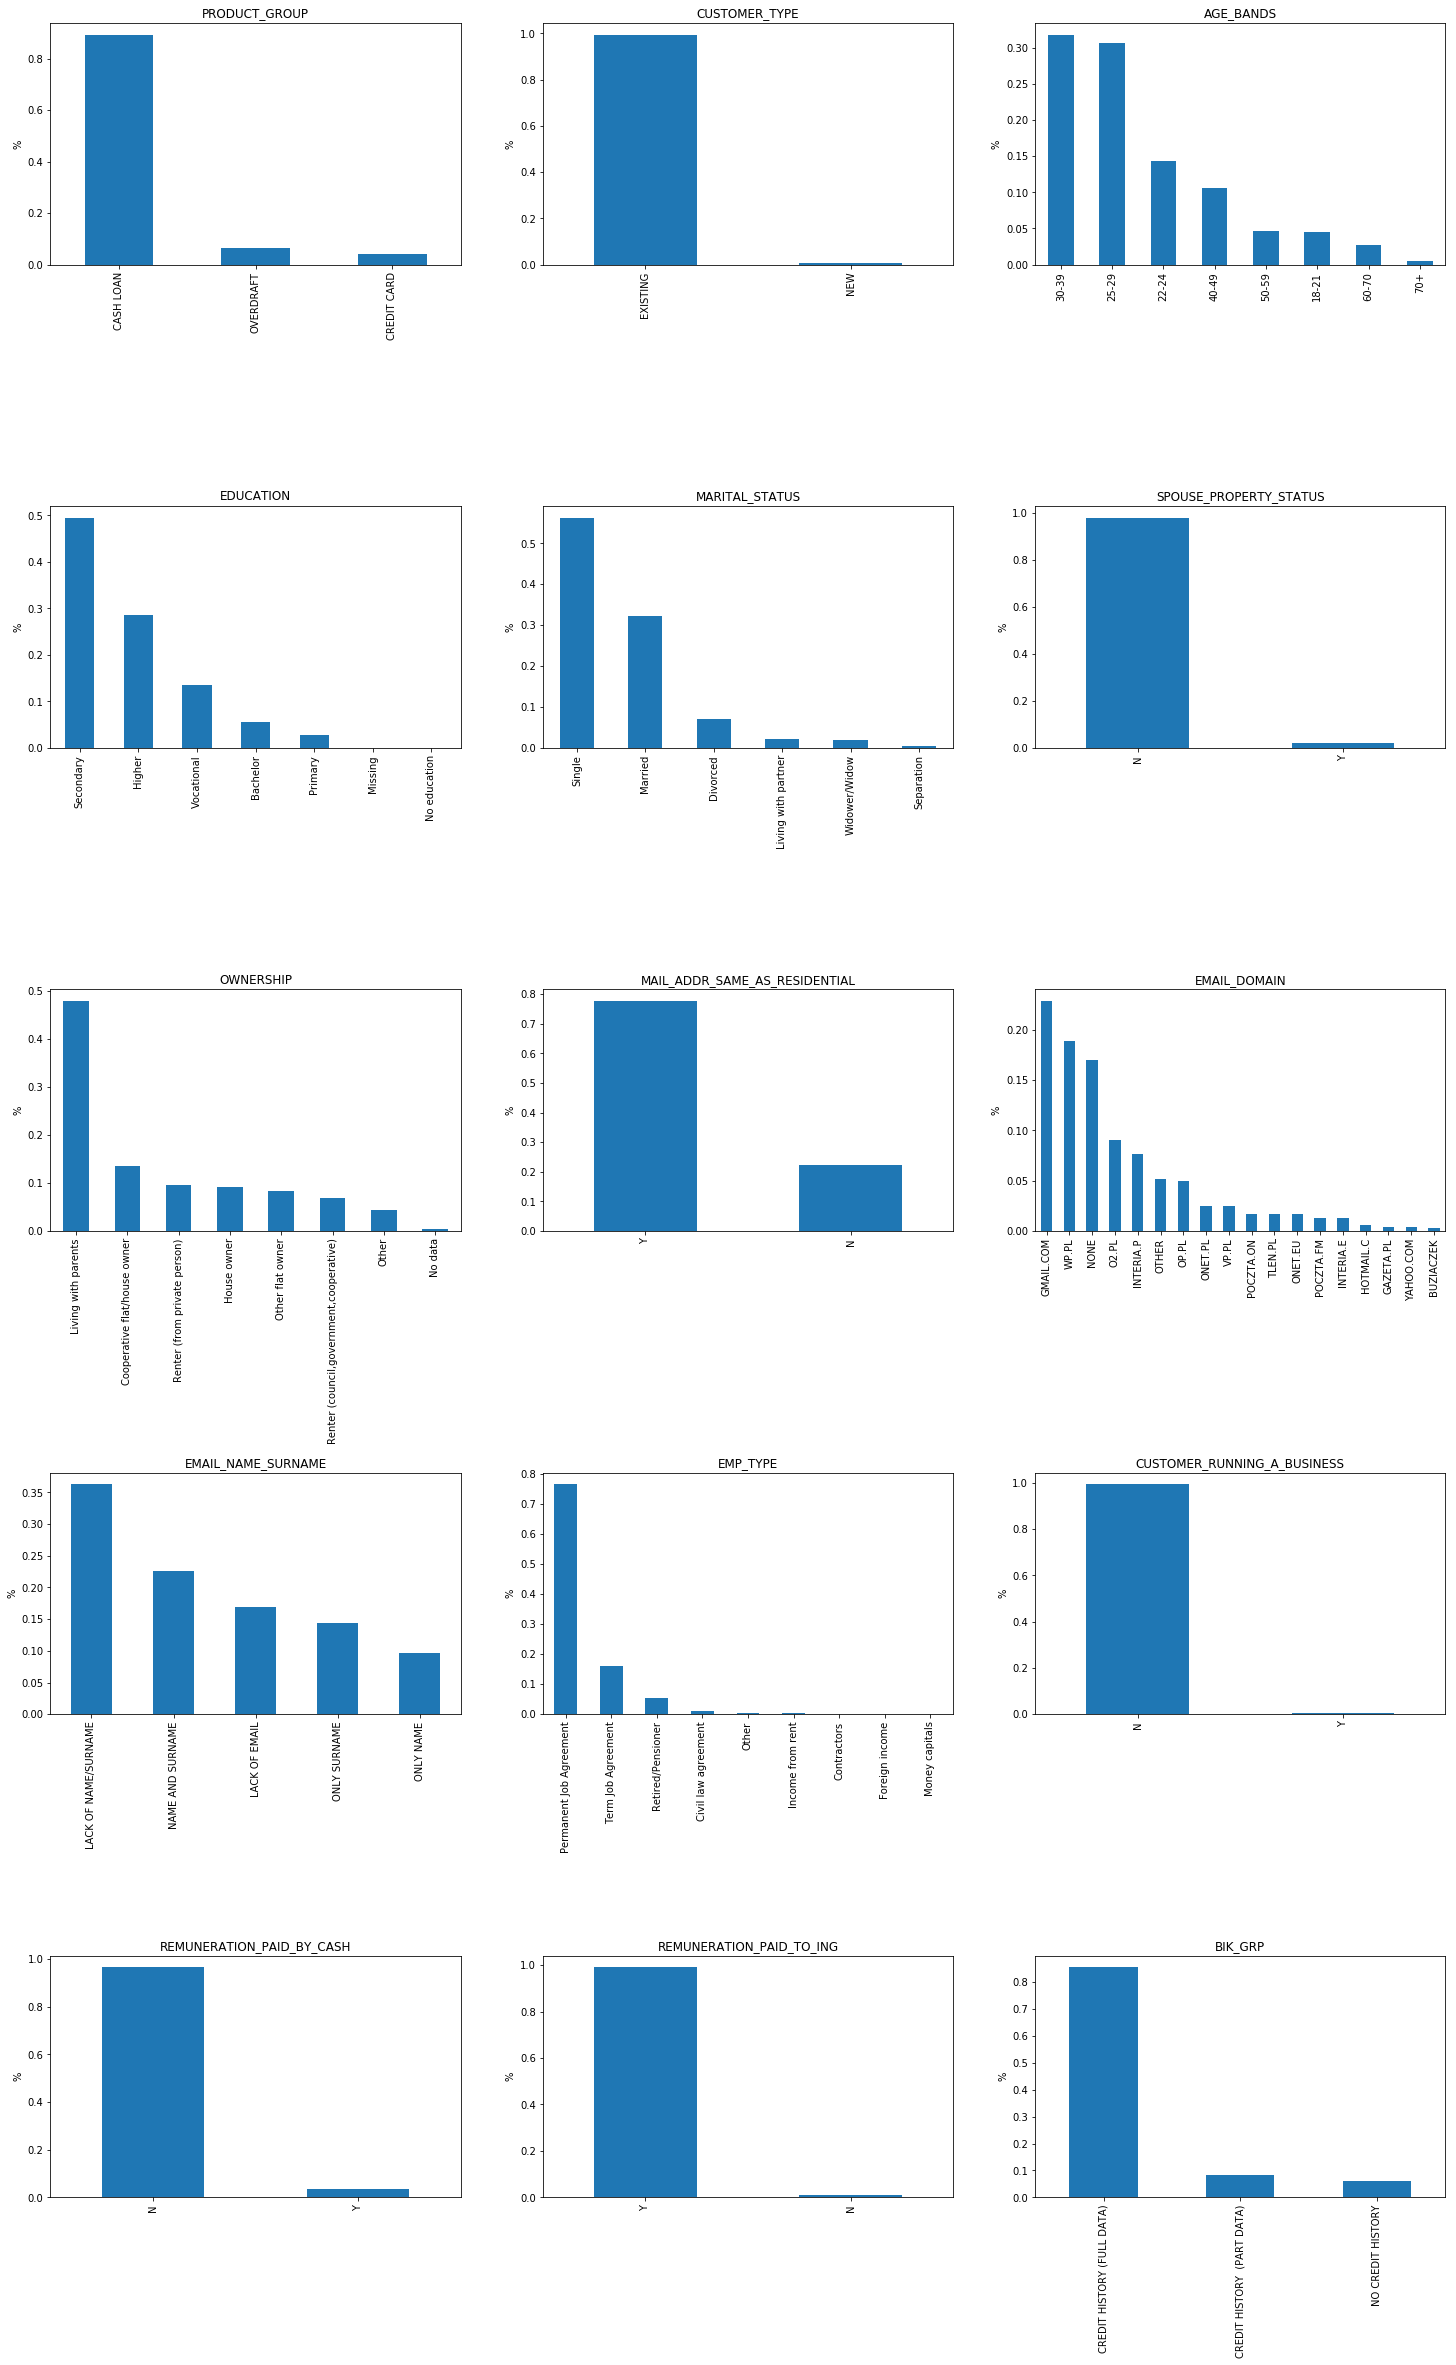

In [11]:
fig = plt.figure(figsize=(25,40))
for i , cecha in enumerate(Kolumny_tekstowe):
    ax = fig.add_subplot(5,3,i+1)
    ax.set_title(cecha)
    (LionsDen[cecha].value_counts()/len(LionsDen[cecha])).plot.bar()
    ax.set(ylabel="%")  
plt.subplots_adjust(hspace = 1, wspace = 0.2)
plt.show()

Teraz sprawdzimy jakie są relacje z zmienną będącą naszym targetem, czyli `DEFAULT_FLAG`. Dla każdej realizacji wyliczam współczynnik default rate

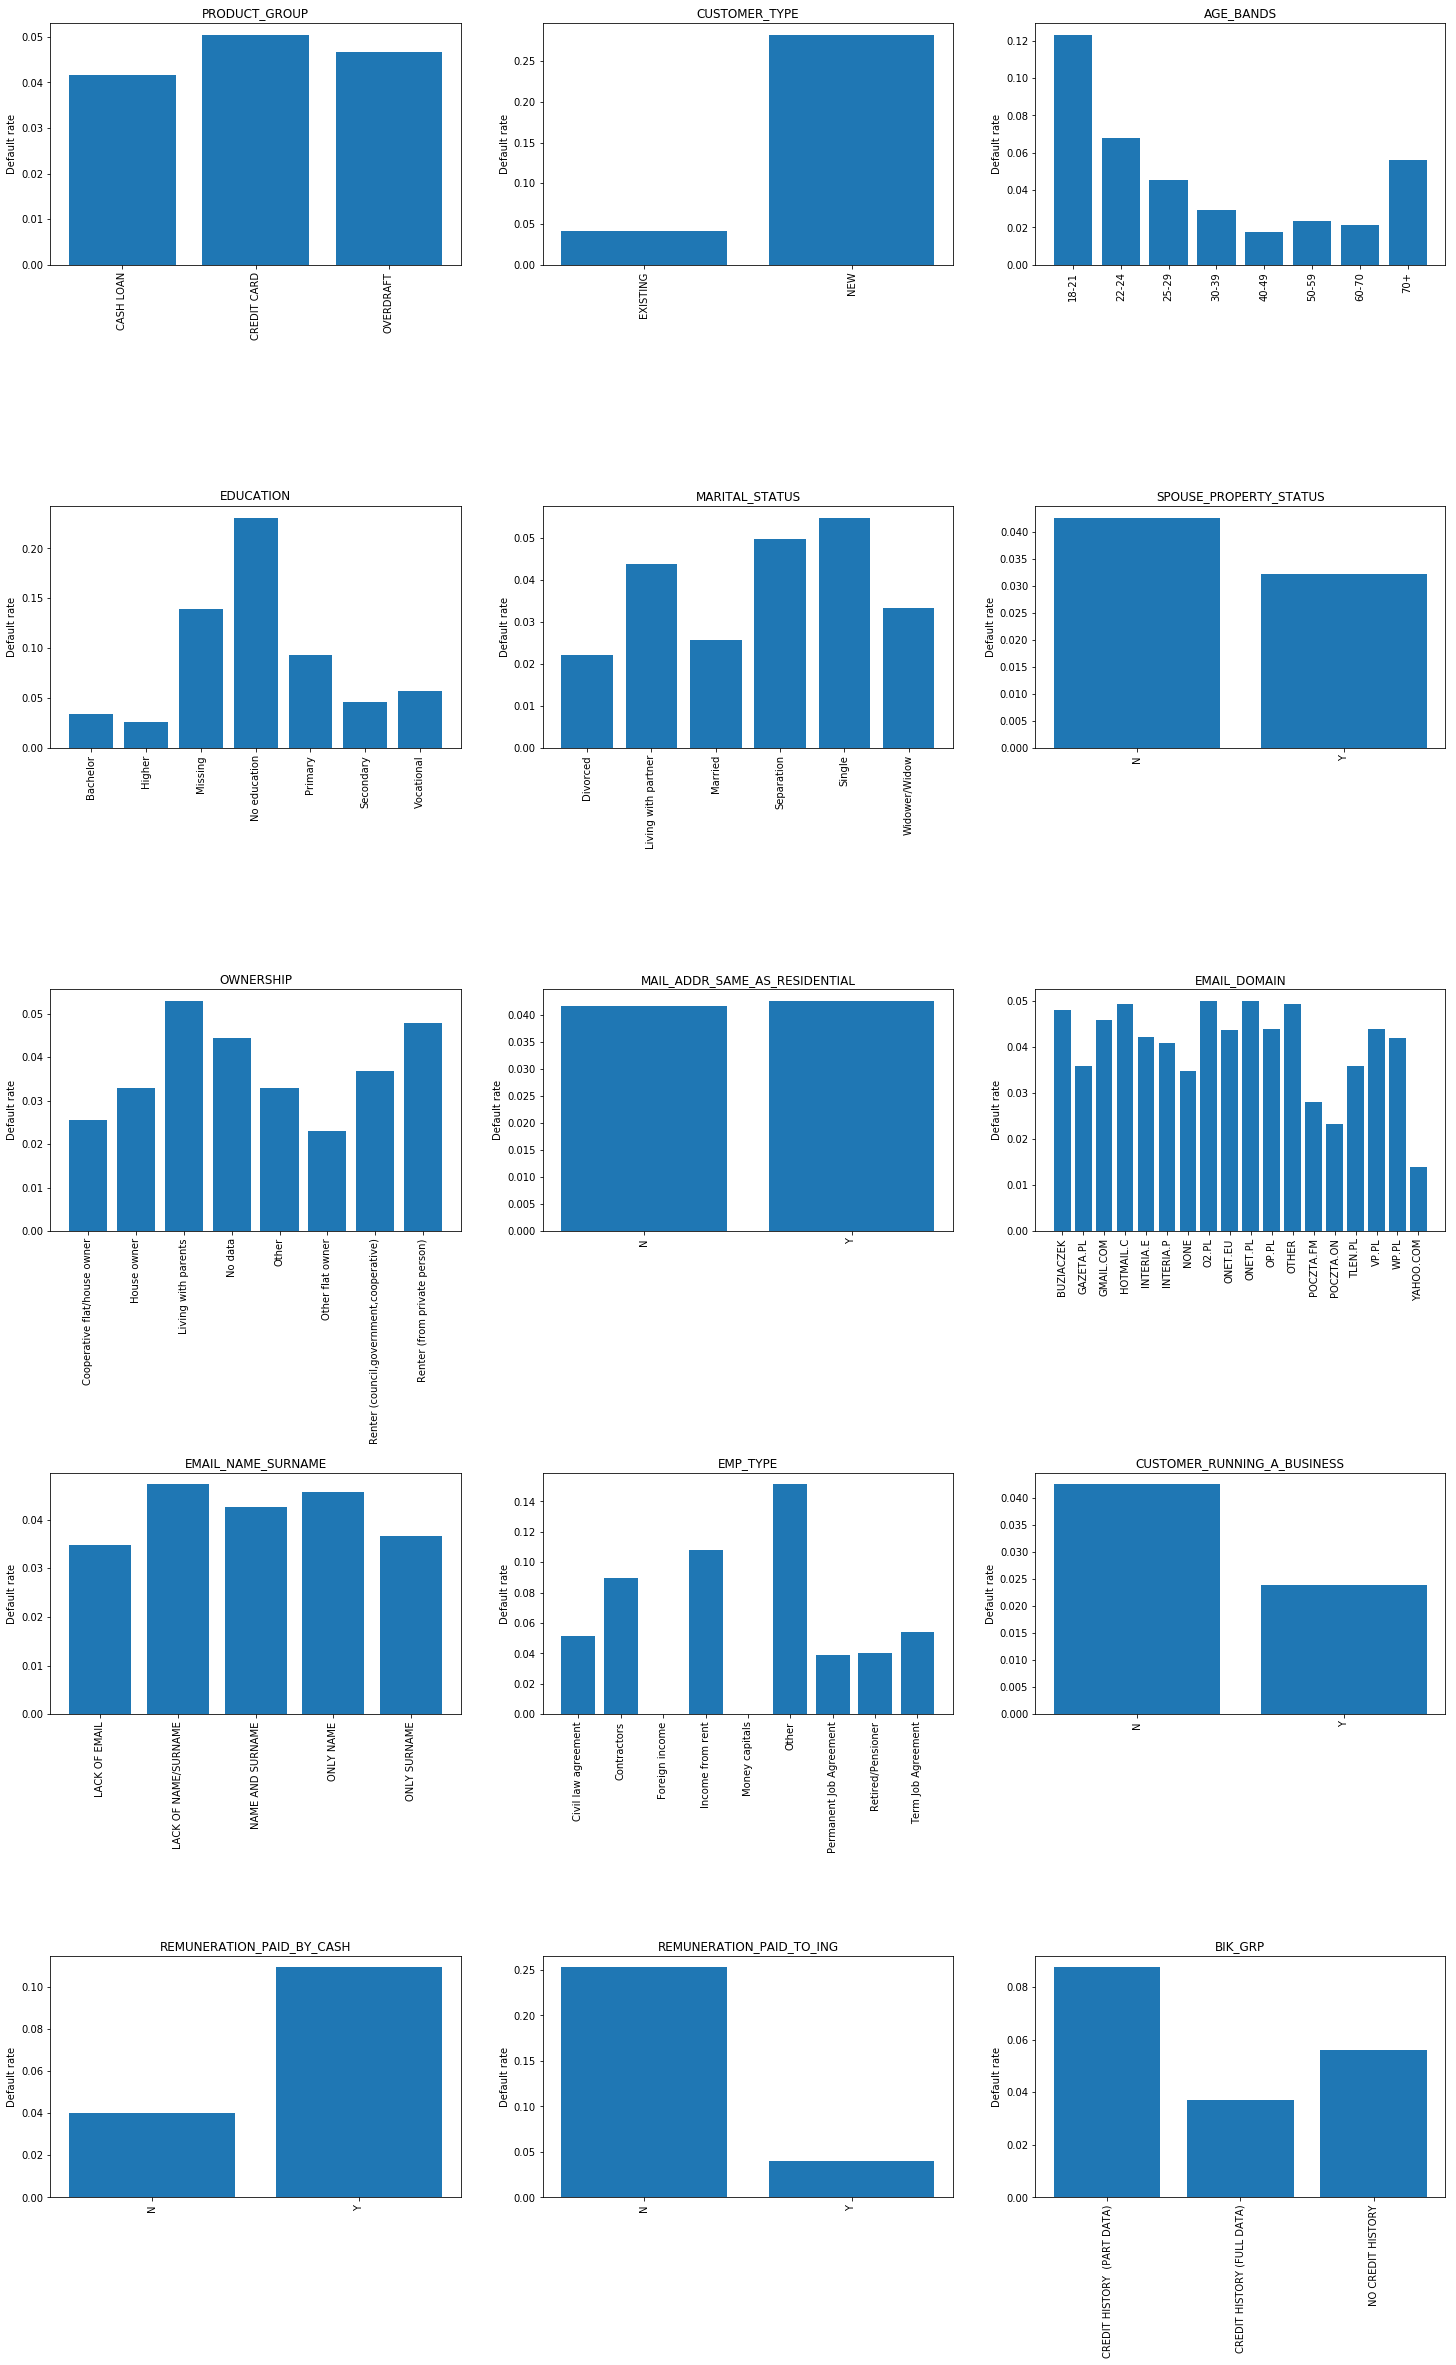

In [12]:
fig = plt.figure(figsize=(25,40))
for i , cecha in enumerate(Kolumny_tekstowe):
    ax = fig.add_subplot(5,3,i+1)
    ax.set_title(cecha)
    ax.set(ylabel="Default rate")  
    a=LionsDen[['DEFAULT_FLAG',cecha]].groupby([cecha]).mean()
    ax.bar(a.index,a.iloc[:,0])
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=90)
plt.subplots_adjust(hspace = 1, wspace = 0.2)
plt.show()

###### Wnioski
Łatwo można zauważyć, że sporo cech posiada takie kategorie, które wykazują się bardzo małą licznością. Stosując niektóre z metod mappingu zmiennych kategorycznych (między innymi One Hot albo WOE - więcej na temat tych metod w kolejnych rozdziałach), klasy takie mogą zaburzyć wynik. Dlatego warto najmniej liczne klasy połączyć ze sobą.Oczywiście trzeba uważać, czy po połączeniu nie pojawi się tylko jedna klasa - wtedy zmienna przestaje być użyteczna. Takie zagrożenie jest dla zmiennych `PRODUCT_GROUP`, `CUSTOMER_TYPE`, `SPOUSE_PROPERTY_STATUS`, `CUSTOMER_RUNNING_A_BUSINESS`, `REMUNERATION_PAID_BY_CASH`, `REMUNERATION_PAID_TO_ING`, `BIK_GRP`.

Trzeba również pamiętać w pozostałych przypadkach, że poprzez połączenie niektórych klas gubimy część informacji. Oczywiście można spojrzeć na rozkład default rate by utwierdzić się w przekonaniu, czy grupy, które chcemy połączyć mogą w podobny sposób dyskryminować(rozróżniać) zmienną celu. Aczkolwiek nie zapominajmy, że to spojrzenie pomija fakt, że dana kategoria w połączeniu z inną cechą może jednak już znacznie lepiej dyskryminować, zwłaszcza jak użyjemy drzewa decyzyjnego. By ograniczyć ryzyko łączenia klas, które już istotnie statystycznie różnią się pod wzgędem default rate, można zastosować testy statystyczne np. chi2 contigency. Niestety nawet ten test ma swoje ograniczenia - np. liczności muszą być licznejsze niż 1. Dlatego nie można go zastosować na przykład do zmiennej `EMP_TYPE`


Poniżej przykładowy test na to, czy kategorie zmiennej `EDUCATION`, które chcemy potencjalnie połączyć, są statystycznie niezależne ze względu na zmienną celu czyli `DEFAULT_FLAG`. 

Hipoteza H0: zmienne są niezależne

Pierwszy krok to stworzenie tablic kontygencji. Później wystarczy skorzystać z gotowej implementacji testu.

In [13]:
education_groupby=LionsDen[LionsDen['EDUCATION'].isin(['Missing',
                                     'No education',
                                     'Primary'])][['DEFAULT_FLAG','EDUCATION']].groupby(['EDUCATION'])
default_count=education_groupby.sum()
non_default_count=education_groupby.count()-education_groupby.sum()
contygency=pd.concat([default_count,non_default_count],axis=1)
print(contygency)
contygency_array=np.array(contygency)
V, p, dof, expected = stats.chi2_contingency(contygency_array)
print(f'\np-value wynosi: {round(p,3)} (>0.05)')
print("Brak podstaw do odrzucenia hipotezy H0")

              DEFAULT_FLAG  DEFAULT_FLAG
EDUCATION                               
Missing                  5            31
No education             3            10
Primary                205          1997

p-value wynosi: 0.158 (>0.05)
Brak podstaw do odrzucenia hipotezy H0


Analizując powyższy wynik, można stwierdzić, że nie ma podstaw by odrzucić tezę o niezależności wybranych klas dla zmiennej `EDUCATION` ze względu na zmienną `DEFAULT_FLAG`. Trzeba również pamiętać o tym, że w przypadku gdy nawet odrzucimy tezę o niezależności, pozostaje kwestia jak silna jest taka zależność. W tym przypadku można użyć np. miary V-Cramera. Jednak aspekty te wykraczają poza zakres projektu, a ze względu na stosowane modele, testowanie różnych metod selekcji zmiennych oraz testowanie różnych próbek oczyszczonych danych (będzie też próbka bez połączonych klas), założenie o połączeniu mniej licznych klas i tak zostanie zweryfikowane przez ostateczny wynik. Dlatego też narazie pomijam te kwestie.

###### `CUSTOMER_TYPE`
Warto zauważyć, że dla kategorii nowy klient występuje bardzo duży odsetek kredytów nie spłaconych. Może to oznaczać, że nowi klienci są potencjalnie bardziej ryzykowni, ale również może to oznaczać, że tak naprawdę mało o nich wiemy przez co stary model pozwalał udzielać kredytów bardzo ryzykownym klientom, ponieważ źle na nich działał. Dlatego może warto zastanowić czy koncepcja zbudowania większej ilości modeli jest zasadna.

### ROZDZIAŁ 3.3 - Analiza danych numerycznych - analiza outliers <a class="anchor" id="#rozdz3.3"></a>

Analizę danych numerycznych zaczniemy od wyodrębnienia odpowiednich zmiennych z bazy

In [14]:
Kolumny_numeryczne=LionsDen.select_dtypes(exclude=['object']).columns

In [15]:
#usuwam zmienne, które we wczśniejszym rozdziale uznaliśmy, że z biznesowego punktu widzenia nic nie wnoszą
Kolumny_numeryczne=Kolumny_numeryczne.drop([
    'CUSTOMER_ID','APPLICATION_ID','DEFAULT_FLAG','APPLICATION_WEEKDAY','APPLICATION_MONTH', 'APPLICATION_YEAR'])

In [16]:
Kolumny_numeryczne

Index(['LOAN_PERIOD', 'CREDIT_AMOUNT', 'COOP_PERIOD', 'CREDIT_COOP_PERIOD',
       'AGE', 'NUMBER_OF_FAMILY_MEMBERS', 'SENIORITY', 'DECLARED_INCOME',
       'INCOME_3M', 'DECLARED_EXPEDITURES', 'NO_INFLOWS', 'NO_NONCASH_CHARGES',
       'NO_CASH_CHARGES', 'SAVING_BALANCE', 'CREDIT_BALANCE',
       'CREDIT_BALANCE_TO_LIMIT', 'DUE_AMOUNT', 'DPD', 'DPD_FALL_IN_12M',
       'BIK_NUM_REQ_TOTAL_LZ3', 'BIK_NUM_REQ_TOTAL_LZ4_12',
       'BIK_ACC_NUM_TOTAL_CLOSE', 'BIK_ACC_NUM_TOTAL_OPEN',
       'BIK_BAL_TOTAL_OPEN', 'BIK_OVERDUE_12M_TOTAL_MAX',
       'BIK_OVERDUE_EVER_TOTAL_MAX'],
      dtype='object')

Kolejnym etapem jest wizualizacja danych, sprawdzenie ich rozkładu. W tym celu wykorzystamy funkcję `distplot` z biblioteki `seaborn`. By móc lepiej stwierdzić, czy dana zmienna dobrze dyskryminuje zmienną celu, naniosłem na siebie dwa wykresy - pierwszy prezentuje rozkład zmiennej w przypadku zajścia zdarzenia default, drugi to rozkład w przypadku braku default.

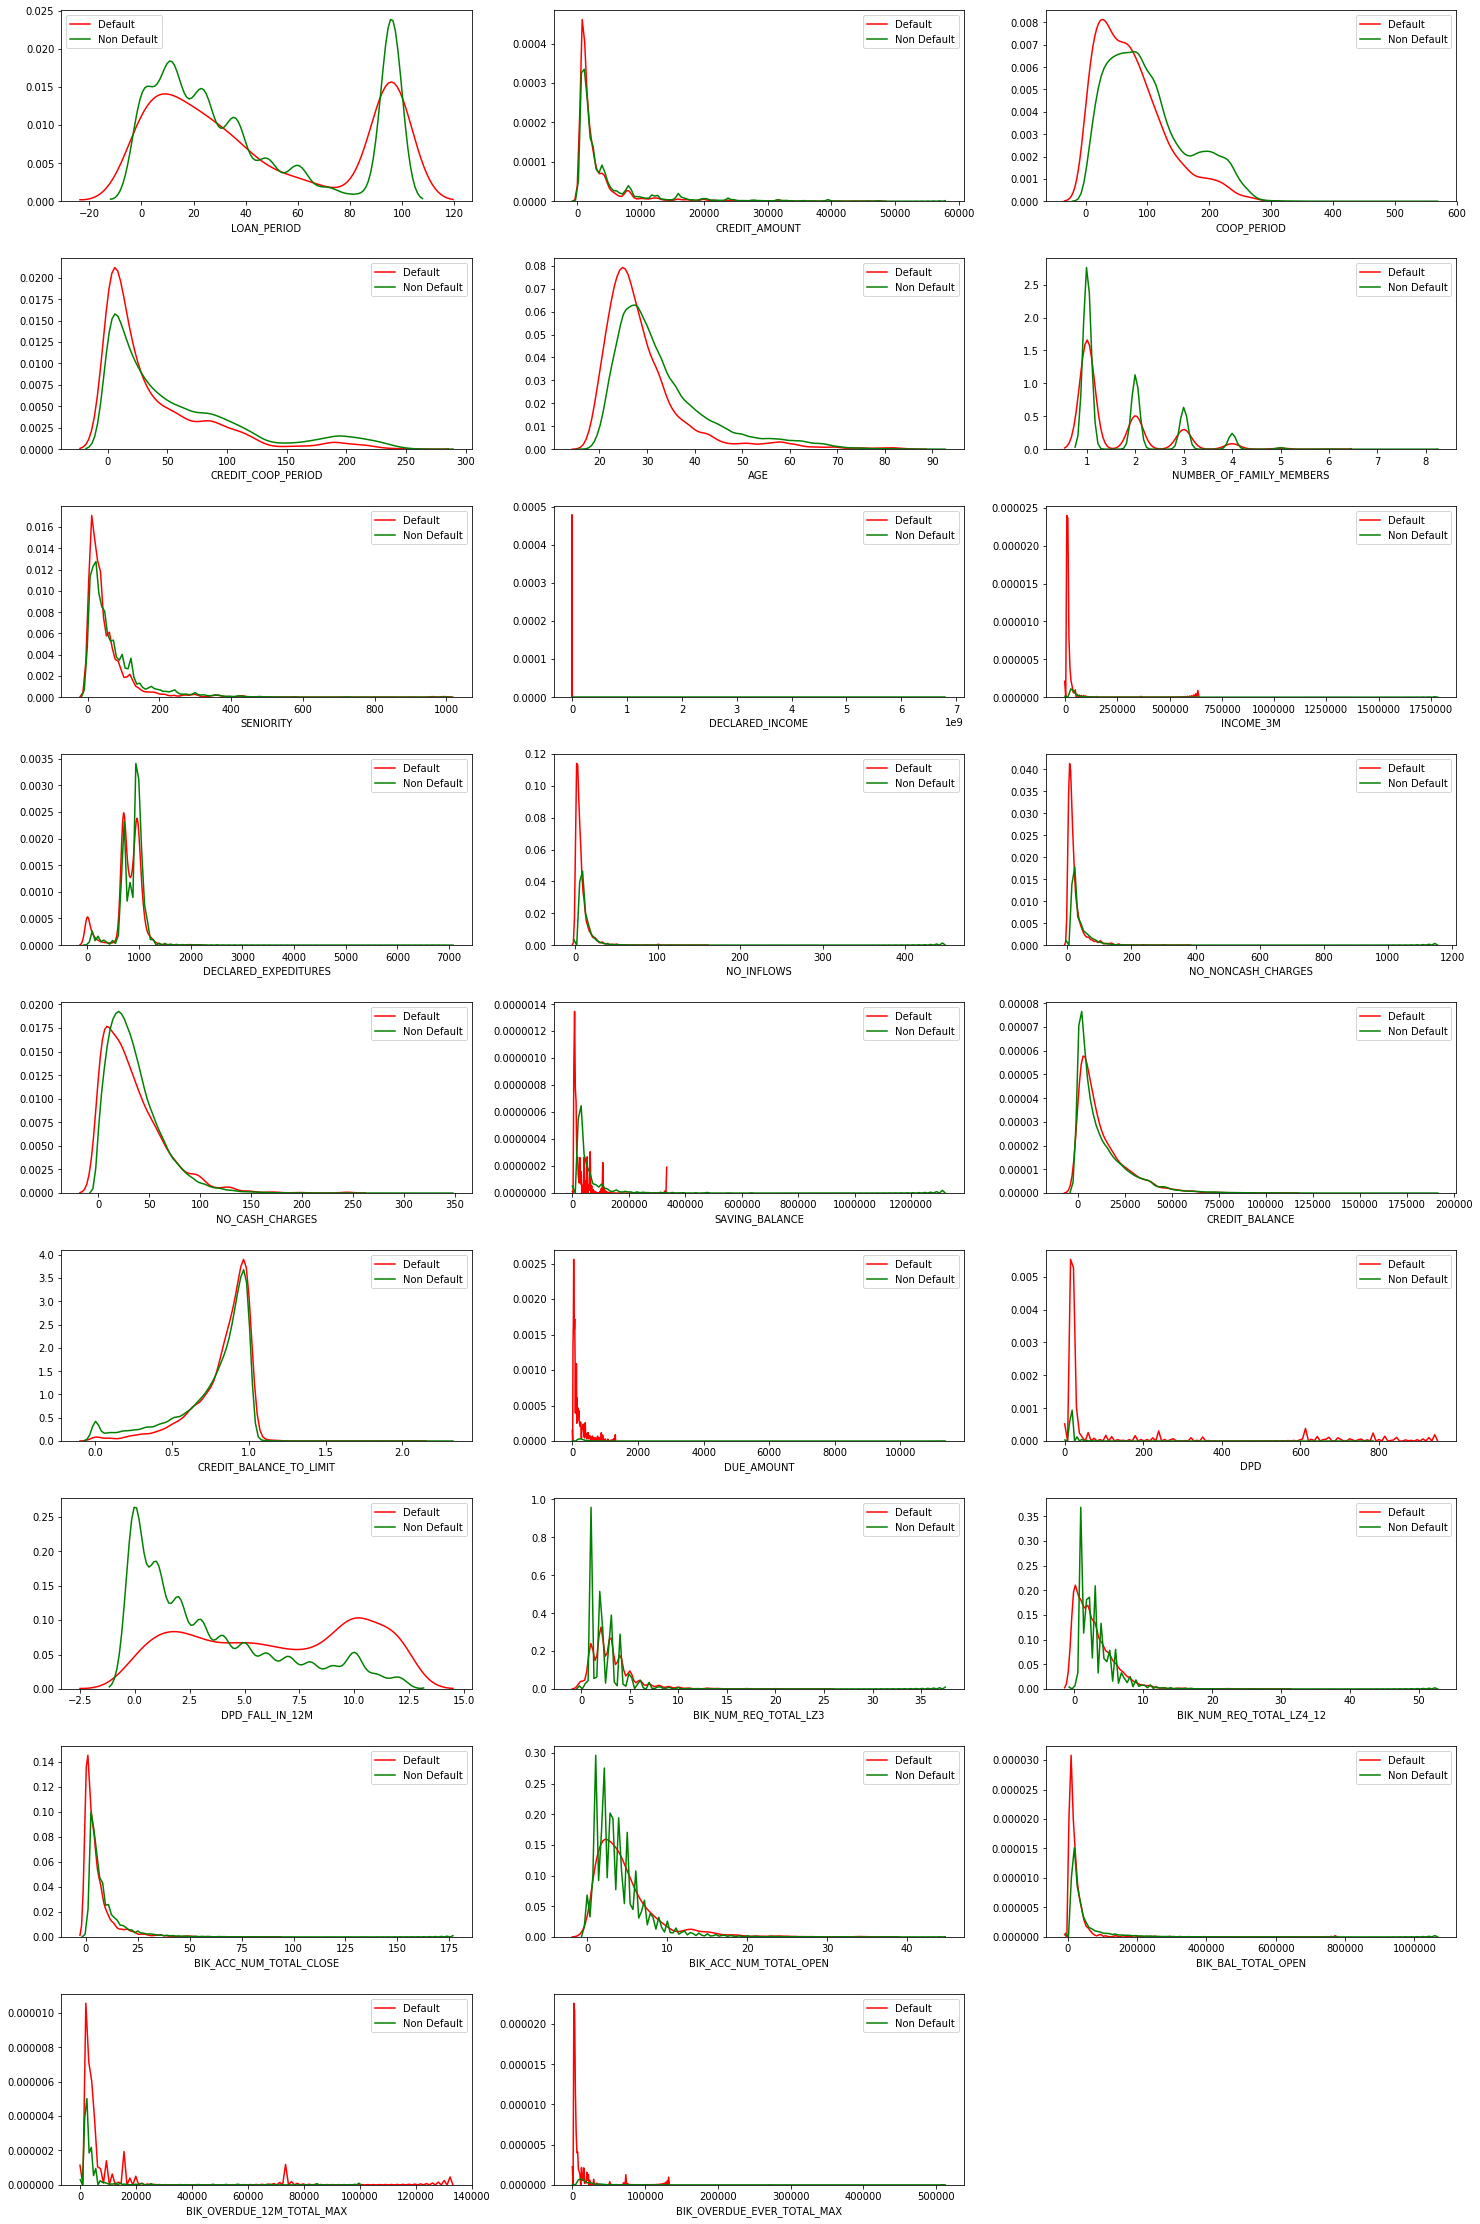

In [17]:
fig = plt.figure(figsize=(25,40))
for i , cecha in enumerate(Kolumny_numeryczne):
    ax = fig.add_subplot(9,3,i+1)
    sns.distplot(LionsDen.loc[LionsDen["DEFAULT_FLAG"]==1,cecha],hist = False, ax=ax,color="red", label="Default")
    sns.distplot(LionsDen.loc[LionsDen["DEFAULT_FLAG"]==0,cecha],hist = False, ax=ax, label="Non Default", color="green")
    plt.legend()
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
plt.show()

Łatwo można zauważyć, że na przykład zmienna `DPD_FALL_IN_12M`, charakteryzuje się tym, że dla coraz większych wartości, prawdopodobieństwo, że obserwacja pochodzi z populacji, gdzie nie zachodzi zdarzenie default maleje. Na przykład dla wartości 11, prawdopodobieństwo, że obserwacja pochodzi z populacji, gdzie zaszło zdarzenie deafult jest kilkukrotnie wyższe od prawdopodobieństwa, że pochodzi z populacji, gdzie nie zaszło te zdarzenie. W przypadku wartości 0 mamy do czynienia z sytuacją odwrotną.

###### Detekcja wartości odstających
Jest bardzo wiele różnych sposobów na detekcję wartości odstających. Przykładem może być sposób, który został zaimplementowany w wykresach typu boxplot, gdzie wartości odstające są wyliczane jako większe niż trzeci kwartyl dodać rozstęp między kwartylowy przemnożony przez 1.5 lub mniejsze niż pierwszy kwartyl odjąć rozstęp między kwartylowy przemnożony przez 1.5. 

(źródło *https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html)* 

Innym sposobem może być test Z-score opierający się na statystyce Z i w tym przypadku mamy do czynienia z wartością odstającą, gdy wartość bezgwlędna statystyki Z przekroczy 3. Najważniejsze to zrozumienie danych i świadomość istnienia wartości odstających, więc skupiłem się tylko na tych dwóch testach. Pierwszy możemy od razu zwizualizować za pomocą wcześniej wspomnianego wykresu typu boxplot.

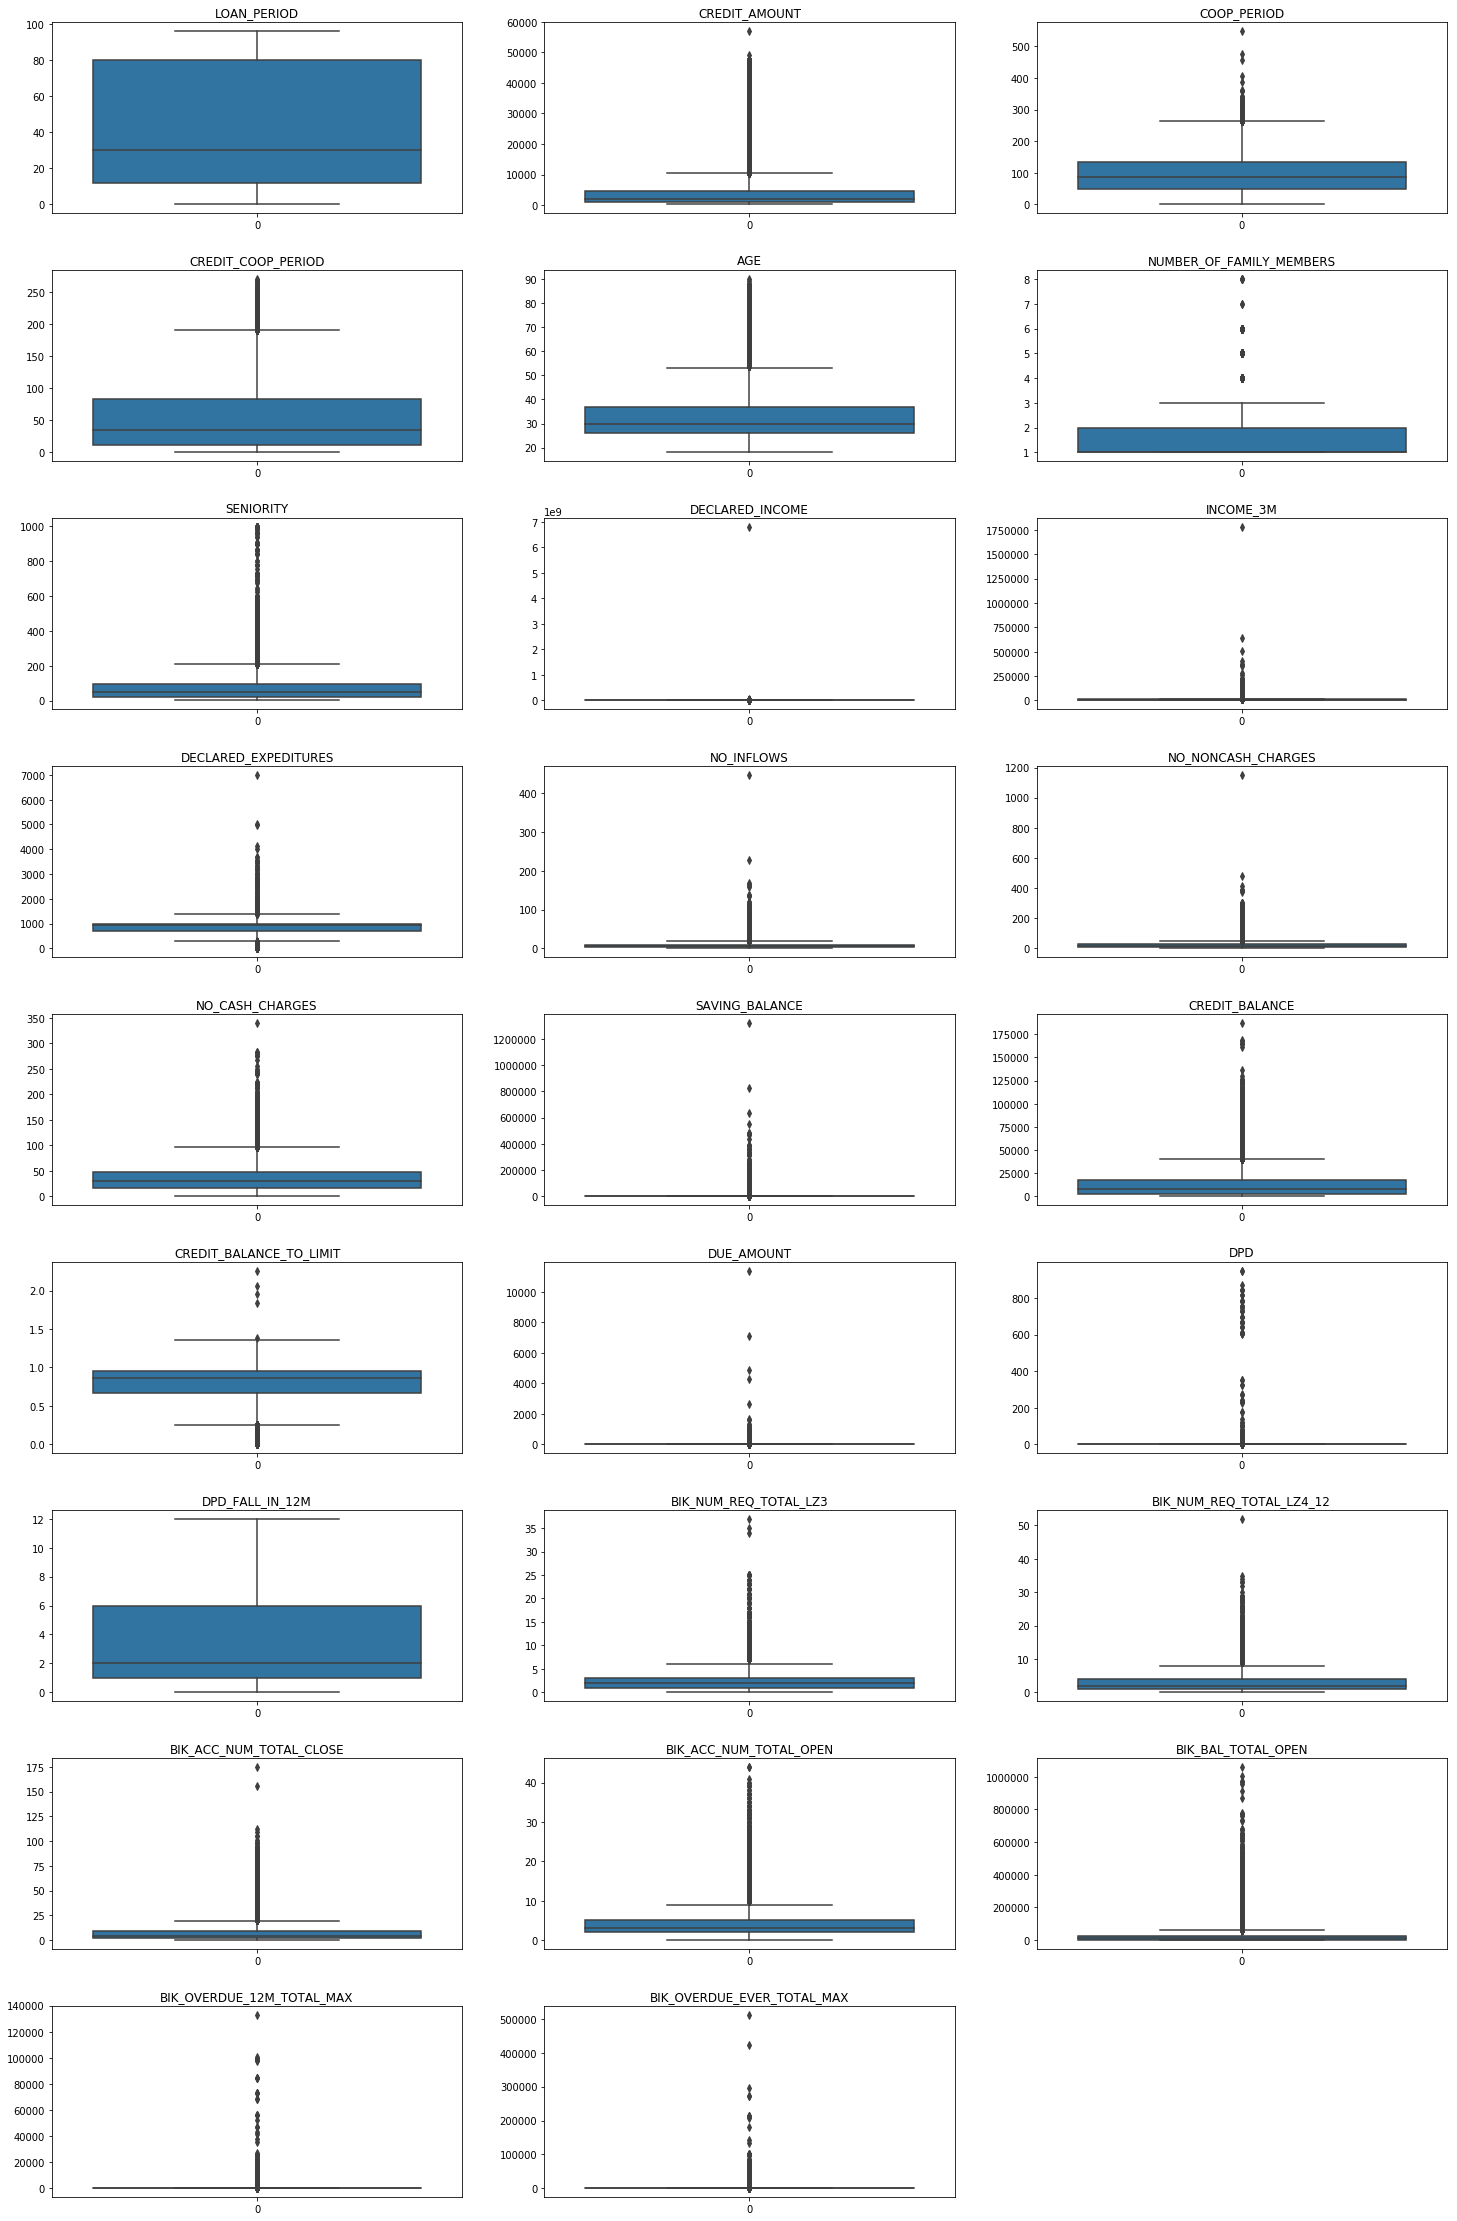

In [18]:
fig = plt.figure(figsize=(25,40))
for i , cecha in enumerate(Kolumny_numeryczne):
    ax = fig.add_subplot(9,3,i+1)
    ax.set_title(cecha)
    sns.boxplot(data=LionsDen[cecha], ax=ax)
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
plt.show()

Druga seria wykresów to `violinplot`, które są tak naprawdę niczym innym jak połączeniem wykresu typu boxplot z estymacją gęstości rozkładu. Czyli na jednym wykresie możemy zobaczyć zarówno gęstość jak i podstawowe informacje na temat kwartyli i wartości odstających.

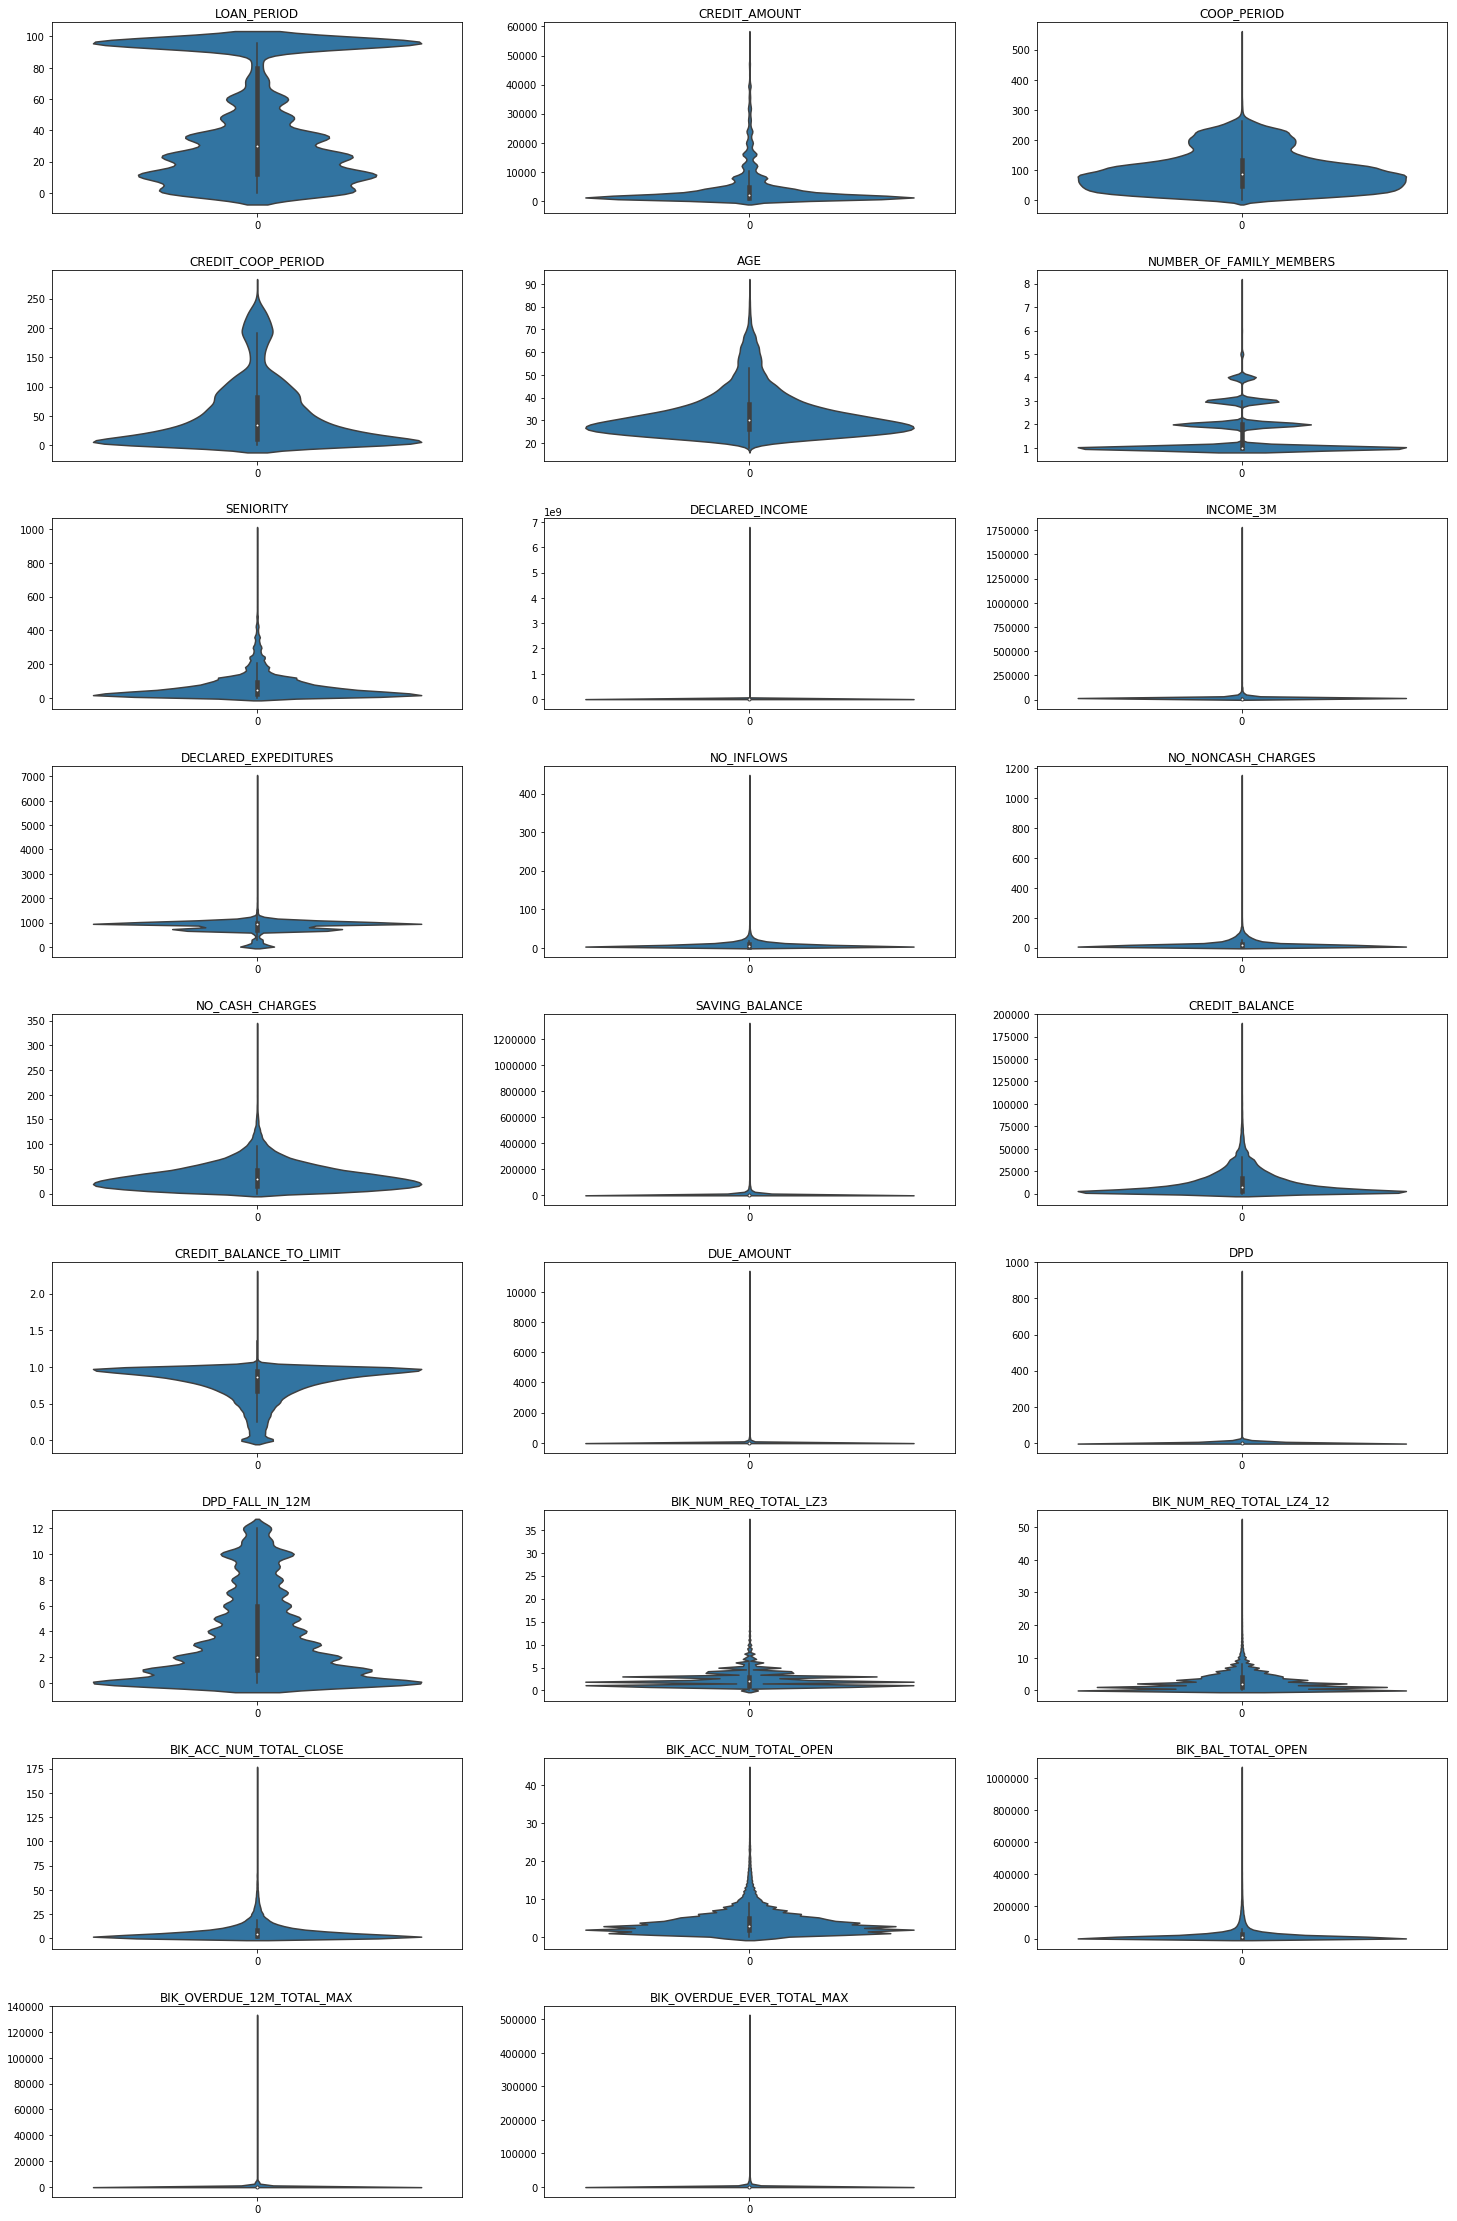

In [19]:
fig = plt.figure(figsize=(25,40))
for i , cecha in enumerate(Kolumny_numeryczne):
    ax = fig.add_subplot(9,3,i+1)
    ax.set_title(cecha)
    sns.violinplot(data=LionsDen[cecha], ax=ax)
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
plt.show()

Oprócz wizualizacji za pomocą wykresów, informacje na temat wartości odstających można umieścić również w tabeli.

In [20]:
#Przygotowanie odpowiednich list
indeks=[]
ilosc=[]
srednia=[]
odchylenie=[]
minimum=[]
maximum=[]
kwartyl1=[]
mediana=[]
kwartyl3=[]
ilosc_out=[]
udzial_out=[]
ilosc_out_z=[]

#Pętla wyliczająca podstawowe informacje
for cecha in Kolumny_numeryczne:
    indeks.append(cecha)
    ilosc.append(LionsDen[cecha].count())
    srednia.append(LionsDen[cecha].mean())
    odchylenie.append(LionsDen[cecha].std())
    minimum.append(LionsDen[cecha].min())
    maximum.append(LionsDen[cecha].max())
    kwar1=LionsDen[cecha].quantile(0.25)
    kwar3=LionsDen[cecha].quantile(0.75)
    kwartyl1.append(kwar1)
    mediana.append(LionsDen[cecha].quantile(0.50))
    kwartyl3.append(kwar3)
    iqr=kwar3-kwar1
    ilosc_out.append(sum(LionsDen[cecha]>kwar3+1.5*iqr)+sum(LionsDen[cecha]<kwar1-1.5*iqr))
    udzial_out.append((sum(LionsDen[cecha]>kwar3+1.5*iqr)+sum(LionsDen[cecha]<kwar1-1.5*iqr))/(LionsDen[cecha].count()))
    ilosc_out_z.append(sum(((LionsDen[cecha]-LionsDen[cecha].mean())/(LionsDen[cecha].std()))>3)+
                      sum(((LionsDen[cecha]-LionsDen[cecha].mean())/(LionsDen[cecha].std()))<-3))
#Finalna tablica
tabela=pd.DataFrame({'Ilość':ilosc,"Średnia":srednia,"Odchylenie":odchylenie,"Minimum":minimum,"Maksimum":maximum,
                    "I kwartyl":kwartyl1,"Mediana":mediana,"III kwartyl":kwartyl3, "Outliers rozstęp":ilosc_out,
                     "Outliers Z-score":ilosc_out_z, "Udział outliersów":udzial_out},index=indeks)

tabela
    

,I kwartyl,III kwartyl,Ilość,Maksimum,Mediana,Minimum,Odchylenie,Outliers Z-score,Outliers rozstęp,Udział outliersów,Średnia
LOAN_PERIOD,12.00000,80.000000,79155,9.600000e+01,30.000000,0.0,3.539007e+01,0,0,0.000000,41.482774
CREDIT_AMOUNT,900.00000,4700.000000,79155,5.700000e+04,2100.000000,200.0,6.685304e+03,2072,9200,0.116228,4667.297075
COOP_PERIOD,49.00000,135.000000,79155,5.480000e+02,86.000000,0.0,6.406675e+01,69,379,0.004788,98.584979
CREDIT_COOP_PERIOD,11.00000,83.000000,79155,2.710000e+02,35.000000,0.0,5.883804e+01,531,4501,0.056863,55.941305
AGE,26.00000,37.000000,79155,9.000000e+01,30.000000,18.0,1.026030e+01,1573,4797,0.060603,33.011800
NUMBER_OF_FAMILY_MEMBERS,1.00000,2.000000,79155,8.000000e+00,1.000000,1.0,9.160927e-01,409,4185,0.052871,1.656257
SENIORITY,22.00000,96.000000,79155,9.960000e+02,47.000000,1.0,8.029742e+01,1742,4828,0.060994,69.889900
DECLARED_INCOME,2150.00000,3490.000000,79155,6.802954e+09,2680.000000,860.0,2.418131e+07,1,4272,0.053970,91034.325437
INCOME_3M,3600.00000,9200.000000,78384,1.781100e+06,5600.000000,100.0,1.235102e+04,829,6323,0.080667,8288.956930
DECLARED_EXPEDITURES,705.91000,983.000000,54563,7.000000e+03,940.000000,0.0,2.651746e+02,1758,3515,0.064421,851.899682


###### Podsumowanie
Oba testy pokazują, że mamy do czynienia prawie w każdym przypadku z wartościami odstającymi. Czasami ilość outliersów sięga nawet 20% (zmienna `SAVING_BALANCE`, gdzie III kwartyl to zaledwie 300PLN, a mediana wynosi 0PLN). 

Zostaje jeszcze kwestia jak poradzić sobie z wartościami odstającymi. Tutaj również jest bardzo sporo różnych metod. Przede wszystkim nie chcemy usuwać danych, gdyż ograniczyłoby to mocno nasz zbiór. Dlatego też wzięte pod uwagę będą dwie metody, których skuteczność zweryfikuje ostateczny wynik. Jedna z nich to użycie do transormacji danych transformaty `RobustScaler`, która zdecydowanie lepiej sobie radzi w przypadku outliersów niż klasyczna standaryzacja. Drugi sposób to przycięcie wartości odstających do granic uznawania je za wartości odstające. Jednak trzeba pamiętać, że ta transformata zniekształci napewno rozkład (w szczegołności dla `SAVING_BALANCE`, gdzie outliers to aż 20%) oraz w skrajnych przypadkach może spowodować, że niektóre zmienne będą miały tylko jedną realizacje (`DUE_AMOUNT` oraz `DPD` -> pierwszy i trzeci kwartyl jest równy 0). Dlatego warto spróbować wydobyć z tych danych jakieś informacje poprzez stworzenie nowych zmiennych (więcej szczegółów w kolejnych rozdziałach)



### ROZDZIAŁ 3.4 - Kwestie braków danych <a class="anchor" id="#rozdz3.4"></a>

W przypadku braków danych (missingów), podstawową rzeczą jest pochodzenie takiego braku. Warto zastanowić się nad przyczyną i czy może już informacja o samym braku nam czegoś nie mówi. W zależności od przyczyn mamy różne metody radzenia się z tym problemem. 

Jeśli chodzi o przyczyny missingów to mamy ułatwione zadanie - opis poszczególnych kolumn tłumaczy z czego mogą wynikać brakujące wartości.

W przypadku danych kategorycznych missingi tworzą osobną kategorię, którą w zależności od metody (WOE albo one OHE) odpowiednio zmapujemy. Ewentualnie jeśli stanowi poniżej 5% połączymy ją z inną klasą.

Co do danych numerycznych zacznijmy od rozpoznania skali problemu i zastanowimy się co dalej.

In [21]:
#Wyliczam procentowy udział missingów - pokazuje cechy dla których występują missingi
udzial=((LionsDen.isnull()).sum())/((~LionsDen.isnull()).sum()+(LionsDen.isnull()).sum())
udzial_oczyszcz=round(udzial[udzial>0],2)

#wyliczam ilości misingów
ilosc_oczyszcz=LionsDen.isnull().sum()[LionsDen.isnull().sum()>0]
podsumowanie=pd.concat([ilosc_oczyszcz,udzial_oczyszcz],axis=1)
podsumowanie.columns=["Ilość missingów","Udział missingów"]
podsumowanie

,Ilość missingów,Udział missingów
INCOME_3M,771,0.01
DECLARED_EXPEDITURES,24592,0.31
NO_INFLOWS,771,0.01
NO_NONCASH_CHARGES,771,0.01
NO_CASH_CHARGES,771,0.01
SAVING_BALANCE,14659,0.19
CREDIT_BALANCE,13279,0.17
CREDIT_BALANCE_TO_LIMIT,13279,0.17
DUE_AMOUNT,13279,0.17
DPD,13279,0.17


Mamy 16 zmiennych zawierających chociaż jeden missing. Jednak możemy pogrupować te missingi ponieważ, często mają wspólną przyczynę i występują dokładnie dla tych samych rekordów.

Jesli chodzi o sposoby radzenia się z missingami to możemy wyróżnić między innymi:
* Usuwanie wierszy z wartościami pustymi -najłatwiejszy sposób, ale z uwagi na utratę informacji, zostabie pominięty na potrzeby niniejszego projektu
* Zmapowanie na inną wartość -> średnią/mediane/dominante. Ze względu na wartości odstające (wcześniejszy podrozdział) najlepszym rozwiązaniem będzie użycie mediany, która jest zdecydowanie bardziej odporna na outliersy. Podejście to nie powoduje utraty danych z całego wiersza, ale uzupełnienie w ten sposób jest napewno sporym uproszczeniem. Może zgubić cenne informację, w przypadku gdy missing niósł za sobą jakąś informację
* Stworzenie nowej zmiennej - przydatne rozwiązanie, zwłaszcza gdy missing niesie za sobą konkretną informację i to ona jest istotna z punktu modelowania. Metoda ta zostanie zastosowana. Wadą jest zwiększenie ilości zmiennych, które oczywiście możemy ograniczyć poprzez odpowiednią selekcję
* Próba prognozowania missingów na podstawie innych danych, np. jeśli mamy możliwość predykcji jednej zmiennej za pomocą innych. Można tutaj skorzystać również z bardziej zaawansowanych metod jak np. `IterativeImputer` z biblioteki `sklearn.impute` (źródło:https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer). Rozwiązanie to wydaje się przydatne w przypadku, gdy na przykład missing ma charakter techniczny i znalezienie podobnych obserwacji pomoże nam określić jego pierwotną wartość.
* Użycie algorytmów wspierających missingi. Jednak użyte w niniejszym projekcie algorytmy będą wymagać zaadresowania problemu missingów

###### `INCOME_3M`, `NO_INFLOWS`, `NO_NONCASH_CHARGES`, `NO_CASH_CHARGES`
Braki dla tych zmiennych oznaczają brak rachunku w banku. Missingi stanowią mniej niż 1%

###### `DECLARED_EXPEDITURES`
Niepokojąca może być duża liczba missingów - ponad 30%. Można zastanowić się czy sam brak mówi nam coś więcej o kliencie.

###### `SAVING_BALANCE`
Bardzo ciekawa zmienna, gdyż udział braków to około 20%, jednak sam brak oznacza, że klient nie ma rachunku oszczednościowego. Pytanie, czy ma znaczenie ile ma oszczędności, czy już sam fakt posiadania jakichkolwiek dobrze świadczą o kliencie. Dodatkowo, jeśli spojrzymy na wykresy rozkładów zmiennych, zauważymy, że dla wartości bliskich zeru jest zdecydowanie większe prawdopodobieństwo, że próbka pochodzi z populacji dla której miało miejsce zdarzenie default. 

###### `CREDIT_BALANCE`, `CREDIT_BALANCE_TO_LIMIT`, `DUE_AMOUNT`, `DPD`
Kolejny ciekawy zestaw danych. Braki oznaczają, że klient nie posiadał wcześniej żadnych produktów kredytowych w naszym banku. Jednak na podstawie tych danych możemy uzyskać znacznie więcej informacji niż tylko odpowiedź na pytanie, czy ma jakikolwiek kredyt. Zmienne behawioralne mogą być bardzo istotne.

###### `DPD_FALL_IN_12M`
Braki danych oznaczają brak produktów kredytowych w ostatnich 12 miesiącach. Odsetek jest zdecydowanie mniejszy niż w przypadku wcześniejszych zmiennych dotyczących również produktów kredytowych. Informacje o tym, czy posiadał jakikolwiek produkt kredytowy jest również bardzo istotna.

###### `BIK_ACC_NUM_TOTAL_CLOSE`, `BIK_ACC_NUM_TOTAL_OPEN`, `BIK_BAL_TOTAL_OPEN`,  `BIK_OVERDUE_12M_TOTAL_MAX`, 

###### `BIK_OVERDUE_EVER_TOTAL_MAX`
Ostatni zestaw zmiennych to zmienne dostarczone z BIK (Biura Informacji Kredytowej). Brak oznacza, że klient nie ma historii kredytowej w żadnym innym banku. Można powiedzieć, że jest nowym klientem na rynku kredytowym. Uwaga- missing to tak naprawdę jedna z kategorii zmiennej `BIK_GRP`. Więc do zastanowienia się, czy nie zamienić zmienną `BIK_GRP` na zmienną zerojedynkową. 

Dodatkowo warto sprawdzić, jaki jest wskaźnik default rate dla missingów, jaki dla wartości równych 0, a jaki dla wartości większych od 1.

In [22]:
#Tworzę listę missingów
lista_miss=[]
for cecha in Kolumny_numeryczne:
    if sum(LionsDen[cecha].isnull())>0:
        lista_miss.append(cecha)
lista_miss

#Wyliczam odpowiednie wskaźniki
for cecha in lista_miss:
    dr_0=LionsDen[LionsDen[cecha]==0]['DEFAULT_FLAG'].sum()/LionsDen[LionsDen[cecha]==0]['DEFAULT_FLAG'].count()
    dr_gt_0=LionsDen[LionsDen[cecha]>0]['DEFAULT_FLAG'].sum()/LionsDen[LionsDen[cecha]>0]['DEFAULT_FLAG'].count()
    dr_null=LionsDen[LionsDen[cecha].isnull()]['DEFAULT_FLAG'].sum()/LionsDen[LionsDen[cecha].isnull()]['DEFAULT_FLAG'].count()
    print(f'''Dla zmiennej {cecha} wskąźnik DR wynosi 
          dla wartości równych 0 = {round(dr_0*100,2)}%,
          dla wartości >0 = {round(dr_gt_0*100,2)}%,
          dla missingów = {round(dr_null*100,2)}%''')

Dla zmiennej INCOME_3M wskąźnik DR wynosi 
          dla wartości równych 0 = nan%,
          dla wartości >0 = 4.03%,
          dla missingów = 25.29%
Dla zmiennej DECLARED_EXPEDITURES wskąźnik DR wynosi 
          dla wartości równych 0 = 10.83%,
          dla wartości >0 = 4.18%,
          dla missingów = 4.02%
Dla zmiennej NO_INFLOWS wskąźnik DR wynosi 
          dla wartości równych 0 = 18.1%,
          dla wartości >0 = 4.02%,
          dla missingów = 25.29%
Dla zmiennej NO_NONCASH_CHARGES wskąźnik DR wynosi 
          dla wartości równych 0 = 10.32%,
          dla wartości >0 = 4.0%,
          dla missingów = 25.29%
Dla zmiennej NO_CASH_CHARGES wskąźnik DR wynosi 
          dla wartości równych 0 = 8.63%,
          dla wartości >0 = 3.97%,
          dla missingów = 25.29%
Dla zmiennej SAVING_BALANCE wskąźnik DR wynosi 
          dla wartości równych 0 = 5.18%,
          dla wartości >0 = 1.56%,
          dla missingów = 5.16%
Dla zmiennej CREDIT_BALANCE wskąźnik DR wynosi 
    

Podsumowując powyższe, łatwo zauważyć, że dla zmiennych `INCOME_3M`, `NO_INFLOWS`, `NO_NONCASH_CHARGES`, `NO_CASH_CHARGES` w przypadku missingów mamy do czynienia z bardzo dużym współczynnikiem DR. Aczkolwiek w przypadku zmiennej 'NO_INFLOWS' już nawet wartości równe 0 charakteryzują się dużym odsetkiem defaultów. Dlatego też uzupełnienie missingów medianą może spowodować, że utracimy sporo cennych informacji.

### ROZDZIAŁ 3.5 - Pozostałe analizy <a class="anchor" id="#rozdz3.5"></a>

Warto zwrócić uwagę na zależności pomiędzy poszczególnymi zmiennymi. Zależności te nie muszą zawsze mieć charakteru liniowego. Czasami metodą radzenia sobie z zależnościami nieliniowymi może być stosowanie modeli, które te zależności uwzględniają (lasy losowe, xgboost). W niniejszym projekcie użyjemy właśnie tego rozwiązania, by zaadresować problem zależności nieliniowych.

Dobrym sposobem analizy zależności pomiędzy zmiennymi jest wizualizacja za pomocą wykresów przy użyciu funkcji `pairplot` z biblioteki `seaborn`. Dzięki zaznaczeniu obserwacji, dla których zmienna celu (`DEFAULT_FLAG`) przyjmuje wartości 1, można szybko zobaczyć, czy widoczne są jakieś zależności, trendy. Ze względu na dużą liczbę zmiennych na poniższym wykresie prezentuję jedynie wycinek obserwacji.

In [23]:
Kolumny_numeryczne_przykladowe=['LOAN_PERIOD', 'CREDIT_AMOUNT', 'COOP_PERIOD', 'CREDIT_COOP_PERIOD',
       'AGE', 'NUMBER_OF_FAMILY_MEMBERS', 'SENIORITY', 'DECLARED_INCOME',
       'INCOME_3M', 'DECLARED_EXPEDITURES','DEFAULT_FLAG']

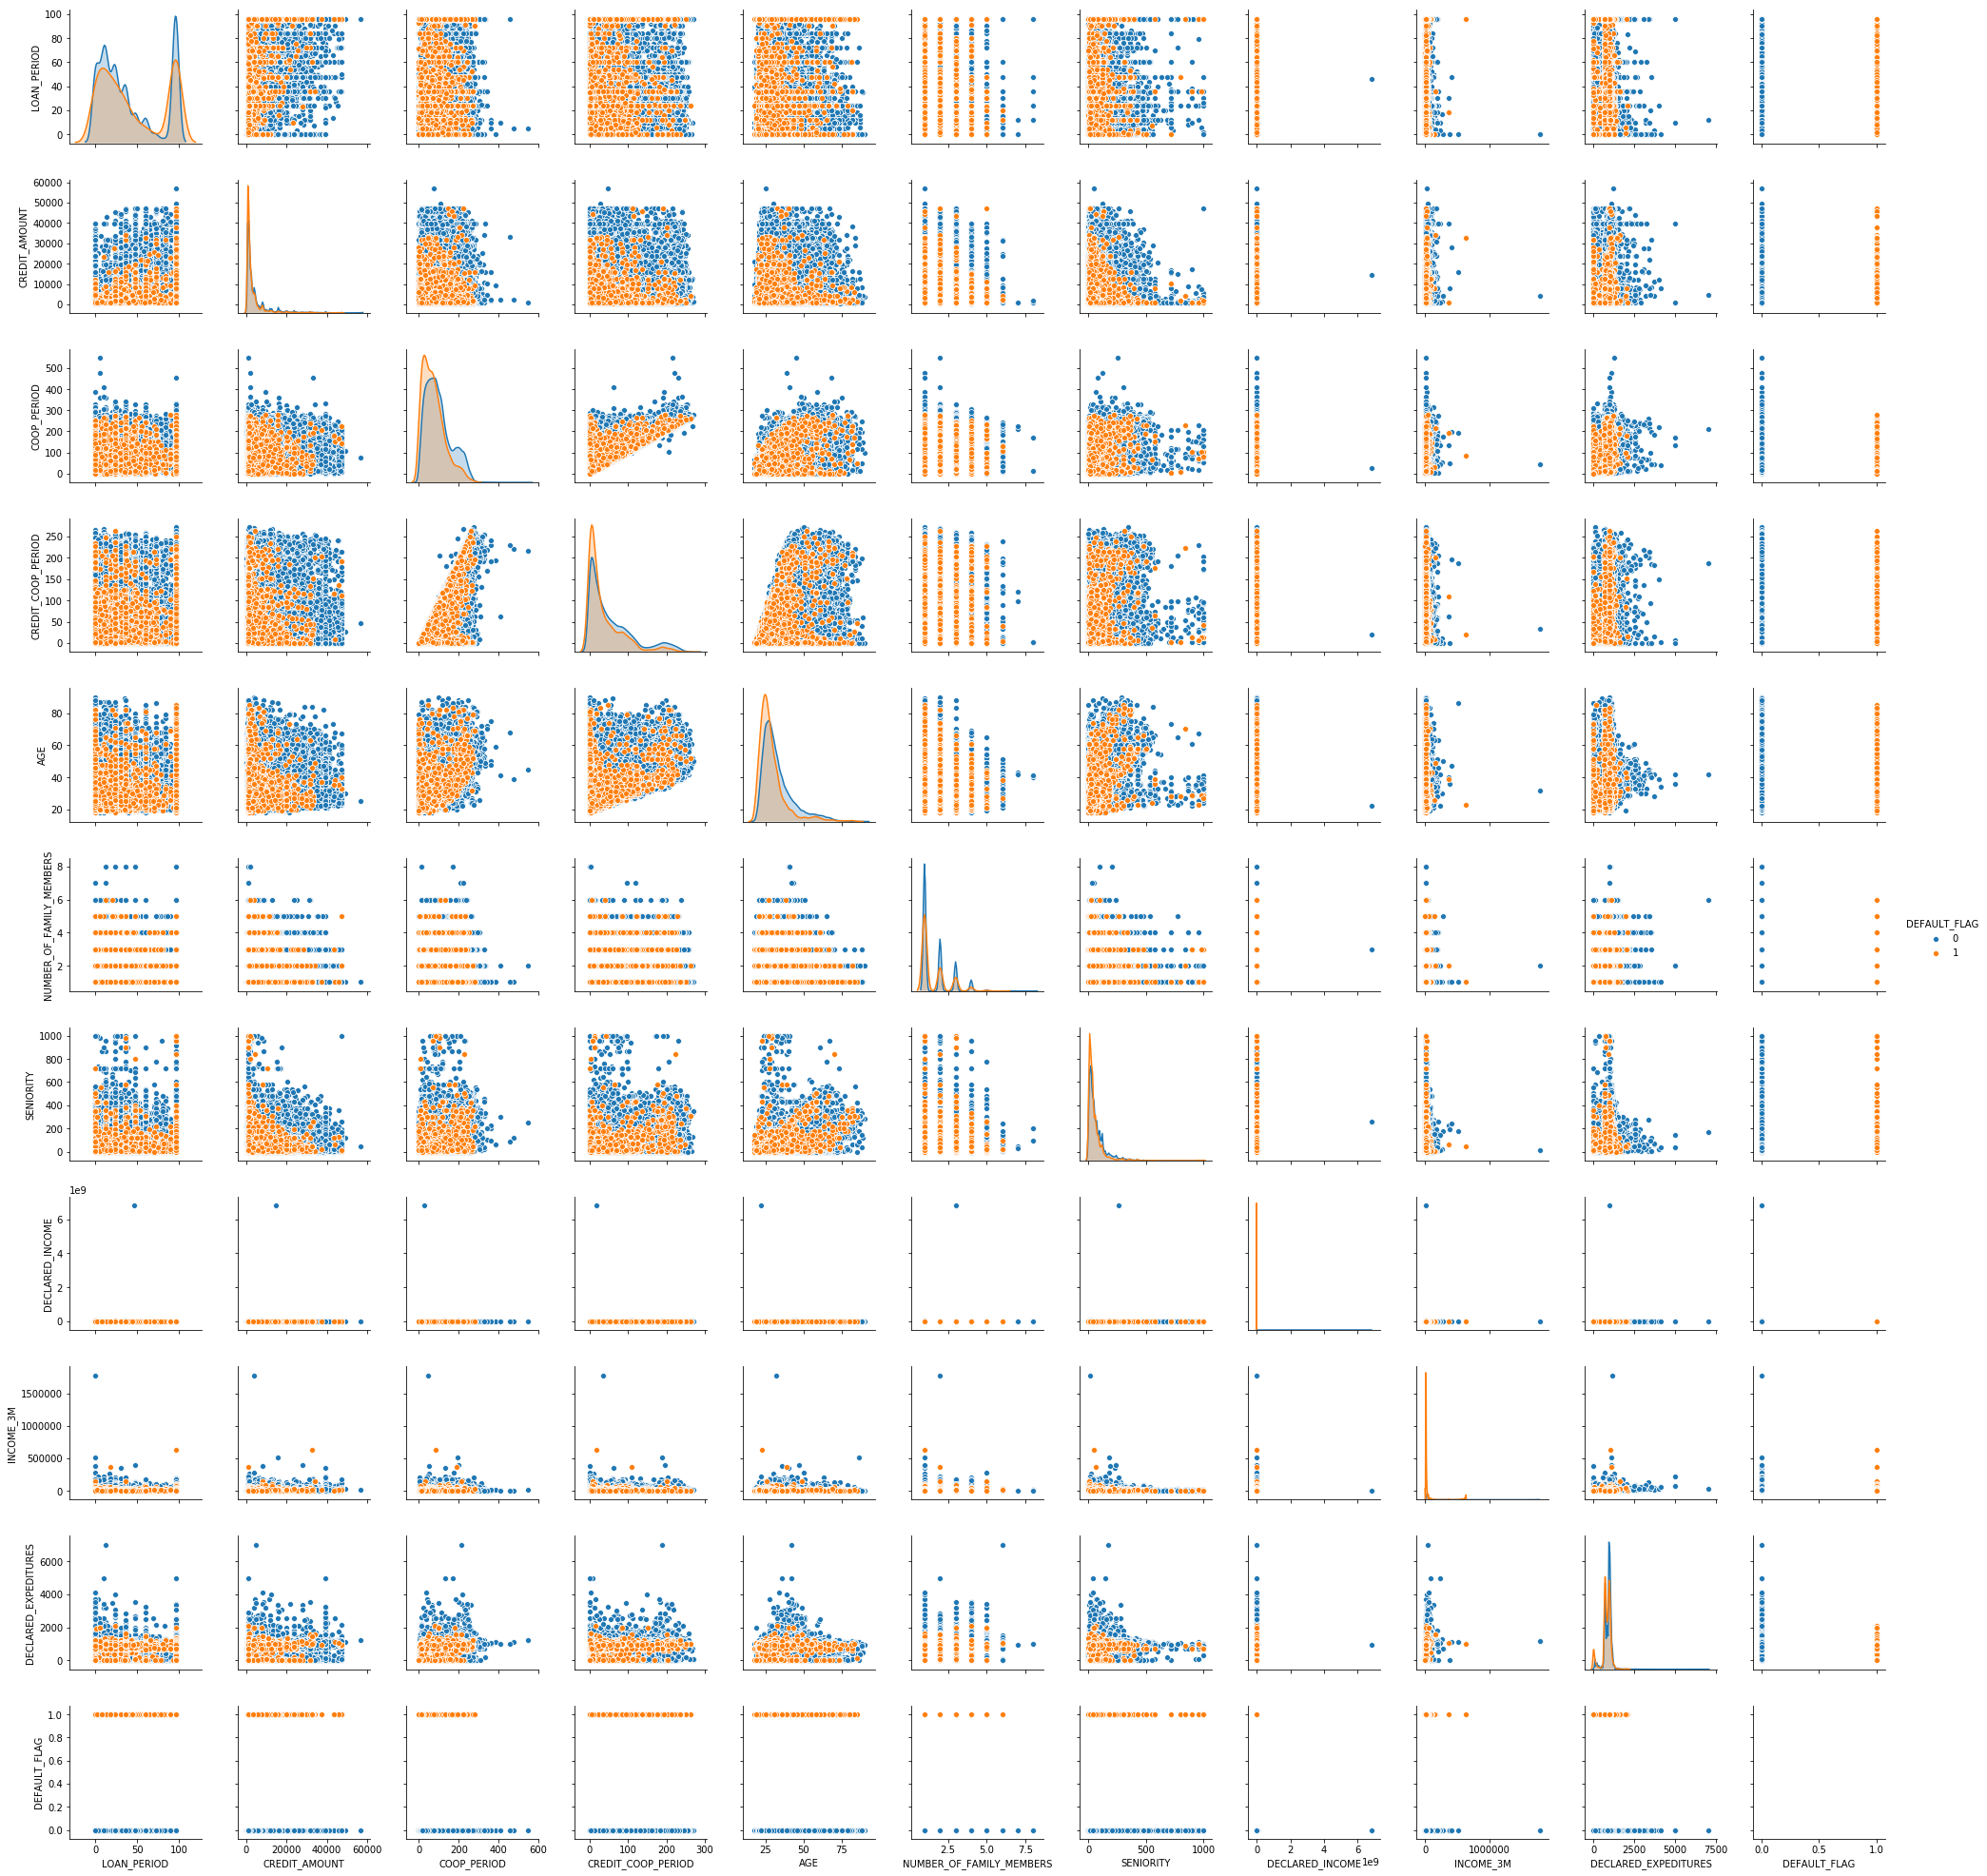

In [24]:
sns.pairplot(LionsDen[Kolumny_numeryczne_przykladowe], hue='DEFAULT_FLAG')
plt.show()

## ROZDZIAŁ 4 - CZYSZCZENIE DANYCH <a class="anchor" id="#rozdz4"></a>

We wcześniejszych rozdziałach opisane zostały niektóre problemy związane z danymi, takie jak wartości odstające, missingi, czy kwestia co zrobić z danymi kategorycznymi. Niniejszy projekt ma na celu również porównanie niektórych podejść, dlatego będą stosowane różne metody. Oczywiście wygeneruje to sporo różnych kombinacji ostatecznego wyniku.

###### Zmienne kategoryczne
Istnieje wiele metod radzenia sobie z zmiennymi kategorycznymi. Metody te można podzielić np. na klasyczne (próba zmapowania etykiety na wartość numeryczną, czy to 0/1 czy zapis binarny itd., jednak wykorzystujemy tylko informację w ramach danej zmiennej) oraz metody wykorzystujące relację z zmienną objaśnianą (źródło: https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159). Postanowiłem wykorzysteć po jednej metodzie z każdej tej grupy:
* kodowanie "gorącojedynkowe" - One Hot Encoding
* WOE - Weight Of Evidence 

###### Braki danych
W tym przypadku braki danych uzupełnimy medianą, ponieważ mamy sporo wartości odstających. Uzupełnienie średnią może być zatem zaburzone. Jednak, jak zostało wspomniane w [rozdziale 3](#rozdz3), uzupełnienie braków medianą może spowodować utratę cennych informacji, zwłaszcza, w przypadku, gdy brak wartości niesie za sobą dodatkową informację. Dlatego też dla niektórych danych zostanie dodana dodatkowa zmienna, która missingi zamieni na kolumnę zero-jedynkową.

###### Wartości odstające
Jak już zostało opisane we wcześniejszym rozdziale, użyjemy 2 metod:
* przytniemy wartości odstające do granic uznawania je za wartości odstające
* przeskalujemy dane używając metody `RobustScaler`, która jest zdecydowanie bardziej odporna na wartości odstające niż zwykła standaryzacja

###### Skalowanie cech
Są metody dla których skalowanie nie ma większego znaczenia (np. lasy losowe), jednakże dla wielu algorytmów, ma to ogromne znaczenie. Na potrzeby ninijeszego projektu użyjemy standaryzacji oraz funkcji skalującej Robust Scaler. Standaryzajcę wykorzystamy wtedy, kiedy wcześniej wykorzystaliśmy przycięcie wartości odstających.


### ROZDZIAŁ 4.1 - Transformacja danych <a class="anchor" id="#rozdz4.1"></a>

W tym rozdziale przygotujemy transformaty, które będą nam potrzebne w kolejnych krokach. Transformaty te bedziemy używać w pipeline'ach, więc powinny być kompatybilne z tym narzędziem. Można to osiągnąć tworząc odpowiednie klasy. W bibliotece `sklearn` znajdziemy wszystkie potrzebne składowe - są tam nawet przygotowane podstawowe klasy z przydatnymi metodami, by nie trzeba było pisać wszystkiego od zera. Jeśli chcemy stworzyć transformatę powinniśmy wykorzystać klasę `TransformerMixin` (zawiera gotową metodę `fit_transform`), jednak by móc korzystać z pipeline powinniśmy użyć również klasy `BaseEstimator`, która dodatkow ma zdefiniowane metody `get_params` oraz `set_params`.

Źrodło:
* https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html
* https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html

###### Zmienne kategoryczne

Jak już zostało wcześniej wspomniane, użyję transformaty WOE. 

<img src="woe.png"> 

In [25]:
class TransformerWOE(TransformerMixin,BaseEstimator):
    
    def __init__(self, cechy):
        self.cechy=cechy

            
    def fit(self,X,y):
        X_new=pd.concat([X, y], axis=1)
        
        target_name=X_new.columns[len(X_new.columns)-1]
        
        self.lista_woe_mapping=[]
        for cecha in self.cechy:
            woe_mapping=dict()
            for x in X_new[cecha].unique():
                non_event=len(X_new[X_new[cecha]==x])-sum(X_new[X_new[cecha]==x][target_name])
                non_event_total=sum(y==0)
                non_event_perc=non_event/non_event_total           
                event=sum(X_new[X_new[cecha]==x][target_name])
                event_total=sum(y==1)
                event_perc=event/event_total
                woe=np.log(non_event_perc/event_perc)
                woe_mapping[x]=woe   
            self.lista_woe_mapping.append(woe_mapping)
        return self
            
    
    def transform(self,X):
        i=0
        for cecha in self.cechy:
            X[cecha]=X[cecha].map(self.lista_woe_mapping[i])
            i=i+1
        return X

Jednak WOE ma swoje ograniczenia. By wyliczyć woe, w każdej kategorii muszą wystąpić obserwacje danego zdarzenia (w tym przypadku defaultu). Dodatkowo udział poszczególnych kategorii nie powinnien być mniejszy niż 5%. (źrodło: https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html).

Dlatego też stworzyłem dodatkową transformatę, która będzie sklejać poszczególne kategorie, których udział stanowi mniej niż 5%.

In [26]:
class TransformerLowCat(TransformerMixin,BaseEstimator):
    
    def __init__(self,cechy):
        self.cechy=cechy

            
    def fit(self, X, y=None):
        self.lista_kateg=[]
        for cecha in self.cechy:
            self.lista_kateg.append([kat for kat in X[cecha].unique() if len(X[X[cecha]==kat])/len(X)>=0.05])
        return self
            
    
    def transform(self,X):
        i=0
        for cecha in self.cechy:
            X.loc[~X[cecha].isin(self.lista_kateg[i]),cecha]='Inne'
            i=1+i
        return X

###### Zmienne numeryczne

Dla zmiennych numerycznych przyda się jeszcze transformata obcinająca wartości odstające

In [27]:
class TransformerOutliers(TransformerMixin,BaseEstimator):
    def __init__(self, cechy):
        self.cechy=cechy

    def fit(self, X, y=None):
        self.Q1=X[self.cechy].quantile(0.25)
        self.Q3=X[self.cechy].quantile(0.75)
        self.IQR=self.Q3-self.Q1
        self.dolna_granica=(self.Q1-1.5*self.IQR)
        self.gorna_granica=(self.Q3+1.5*self.IQR)
        return self
    
    def transform(self,X):
        for cecha in self.cechy:
            X.loc[X[cecha]<self.dolna_granica[cecha],cecha]=self.dolna_granica[cecha]
            X.loc[X[cecha]>self.gorna_granica[cecha],cecha]=self.gorna_granica[cecha]
        return X

### ROZDZIAŁ 4.2 - Dodanie nowych zmiennych <a class="anchor" id="#rozdz4.2"></a>

Czasami brak danych może nieść za sobą jakąś informację. Na przykład w przypadku zmiennej `SAVING_BALANCE`, brak danych oznacza, że klient nie ma konta oszczednościowego w naszym banku. Może okazać się, że nie ważna jest wartość na koncie oszczednościowym, ale sam fakt jego posiadania. Oczywiście klient może też posiadać analogiczne konto oszczędnościowe w innym banku. Temat ten był już poruszany w [rozdziale 3](#rozdz3) i wtedy zauważyliśmy, że w przypadku tej zmiennej, zarówno dla braków danych, jak również dla wartości równych 0, występuje duże prawdopodobieństwo defaultu. Dlatego zostanie stworzona nowa kolumna, gdzie wartość 1 będzie oznaczała posiadania jakichkolwiek oszczędności na koncie (dla wartości >0), a wartość 0 brak posiadania oszczędności lub brak posiadania konta oszczędnościowego w naszym banku. W analogiczny sposób można podejść do zmiennych `DUE_AMOUNT` oraz `NO_INFLOWS`.

Z kolei dla zmiennej `INCOME_3M` w przypadku missingu, default rate jest na tyle duży, że stworzona zostanie osobna kategoria. Dodatkowo zgodnie z informacją na temat pochodzenia missingów w przypadku tej zmiennej, taki missing oznacza brak rachunku bieżącego.

Stosujac rozwiązanie polegające na przycięciu wartości odstających dwie zmienne `DUE_AMOUNT` oraz `DPD` posiadałoby już tylko jedną realizację równą 0 (w obu przypadkach pierwszy i trzeci kwartyl jest równy 0). O pierwszej zmiennej wspominałem 2 akapity wyżej. W przypadku `DPD`, po głębszej analizie rozkładów gęstości, zaproponowane zostało rozwiązanie stworzenia nowej zmiennej, która przyjmuje wartość dla `DPD` >30. 

Ostatnią propozycją jest wykorzystanie zmiennej `DPD_FALL_IN_12M` i na jej podstawie stworzymy nową zmienną, która przyjmuje wartość 0 w przypadku gdy `DPD_FALL_IN_12M` przyjmuje wartość 0, oraz wartość 1 dla wszystkich pozostałych obserwacji, w tym braków danych.

Zauważmy, że niejednokrotnie brak danych traktujemy bardzo konserwatynie, np . w przypadku `SAVING_BALANCE`, braki traktujemy na równi z posiadaniem zerowych oszczędności, a w przypadku `DPD_FALL_IN_12M` na równi z posiadaniem jakiegokolwiek opóźnienia. Oczywiście argumentem stojącym za tym podejściem była wartość deafult rate. Jednak dobrze mieć świadomość takiego założenia i w przyszłości warto przeanalizować jego dalszą słuszność.



In [28]:
#stworzy nową zmienną zero-jedynkową na podstawie missingów w innej, gdzie 0 to brak missingu, a 1 to missing
class TransformerNewFeatNonNuLL(TransformerMixin,BaseEstimator):
    def __init__(self, cechy):
        self.cechy=cechy

    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        for cecha in self.cechy:
            X[cecha]=np.where(X[cecha].isnull(),1,0)
        return X

In [29]:
#stworzy nową zmienną zero-jedynkową na podstawie innej, gdzie wartości powyżej 0 to 1, a wszystko pozostałe to 0
class TransformerNew(TransformerMixin,BaseEstimator):
    def __init__(self, cechy):
        self.cechy=cechy

    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        for cecha in self.cechy:
            X[cecha]=np.where(X[cecha]>0,1,0)
        return X

In [30]:
#stworzy nową zmienną zero-jedynkową na podstawie innej, gdzie wartości powyżej 30 to 1, a wszystko pozostałe to 0
class TransformerNewDPD(TransformerMixin,BaseEstimator):
    def __init__(self, cechy):
        self.cechy=cechy

    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        for cecha in self.cechy:
            X[cecha]=np.where(X[cecha]>30,1,0)
        return X

In [31]:
#stworzy nową zmienną zero-jedynkową na podstawie innej, gdzie wartości równe 0 to 0, a wszystko pozostałe to 1
class TransformerNewDPD12M(TransformerMixin,BaseEstimator):
    def __init__(self, cechy):
        self.cechy=cechy

    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        for cecha in self.cechy:
            X[cecha]=np.where(X[cecha]==0,0,1)
        return X

### ROZDZIAŁ 4.3 - Przygotowanie zbiorów treningowych i uczących <a class="anchor" id="#rozdz4.3"></a>

Zaczniemy od podziału próbki na zbiór testowy i uczący. W zależności od zastosowanych transformat powstaną różne zestawy zmiennych, jednak wszystkie te transformacje przeprowadzimy już po podziale na zbiór testowy i uczący.

Aczkolwiek biorąc pod uwagę analizy z [rozdziału 3](#rozdz3), jest zestaw zmiennych, które zawsze będziemy usuwać, dlatego zrobimy to na samym początku

In [32]:
Lista_do_usuniecia=['CUSTOMER_ID','APPLICATION_ID', 'APPLICATION_DATE','APPLICATION_HOUR', 'APPLICATION_WEEKDAY',
                    'APPLICATION_MONTH', 'APPLICATION_YEAR', 'MARKETING_CONSENT'] #na podstawie rozdziału 3
LionsDen_final=LionsDen.drop(Lista_do_usuniecia,axis=1)

In [33]:
X, y = LionsDen_final.drop(['DEFAULT_FLAG'],axis=1), LionsDen_final['DEFAULT_FLAG']
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=2423)

In [34]:
#Sprawdzenie ilości defaultów w próbce treningowej i testowej:
print(f"W próbie treningowej default rate wynosi: {round(y_train.mean()*100,4)}%")
print(f"W próbie testowej default rate wynosi: {round(y_test.mean()*100,4)}%")

W próbie treningowej default rate wynosi: 4.2401%
W próbie testowej default rate wynosi: 4.2448%


Biorąc pod uwagę, że chcemy zastosować 2 różne metody na poradzenie sobie z zmiennymi kategorycznymi i 2 metody by poradzić sobie z wartościami odstającymi, użyjemy 4 różnych pipeline'ów. dzięki czemu otrzymamy 4 różne zbiory do modelowania. By ocenić, czy i jak bardzo proces czyszczenia danych, ma jakiekolwiek znaczenie, stworzymy jeszcze jeden zestaw danych, gdzie missingi zastąpimy medianą oraz wartości kategoryczne za pomocą metody OHE zamienimy na odpowiednie kategorie zmiennych zero-jedynkowych.

Będzie też potrzeba użycia różnych transformat w zależności od rodzaju zmiennych (np. OHE użyjemy tylko do zmiennych kategorycznych, WOE tak samo, a dla zmiennych numerycznych użyjemy przycięcia wartości odstających, czy też standaryzacji). Dlatego przyda się transformata, które wybierze tylko interesujące nas zmienne i takie zmienne będziemy dalej obsługiwac w pipeline.

In [35]:
class TransformerFeature(TransformerMixin,BaseEstimator):
    
    def __init__(self,cechy):
        self.cechy=cechy

    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        return X[self.cechy]

In [36]:
#Tworze listy zmiennych, które będą mi potrzebne przy tworzeniu transformat, 
#Robie tak ponieważ niektóre transformaty będą wykonywać operację tylko na wybranych zmiennych
#Zaczynam od podstawowego podziału na zmienne numeryczne i tekstowe:
txt_list=LionsDen_final.select_dtypes(include=['object']).columns
numeric_list=LionsDen_final.select_dtypes(exclude=['object']).columns
numeric_list=numeric_list.drop("DEFAULT_FLAG")
#Dla zmiennych kategorycznych, jak zostało wspomniane powyżej, małoliczne klasy będę łączyć.
#Nie dla wszystkich zmiennych wykonujemy tą operację, ponieważ, czasami nie dałaby żadnego skutku
#np. są dwie klasy i jedna ma mniej niż 5%
merge_cat_list=['AGE_BANDS', 'EDUCATION','MARITAL_STATUS', 'OWNERSHIP', 'EMAIL_DOMAIN', 'EMAIL_NAME_SURNAME', 'EMP_TYPE']
#na potrzeby OHE wybieram odpowiednie zmienne kategoryczne- raz wszystkie,
#a gdy robie WOE to tylko te, dla których Transformacja WOE nie ma sensu i potrzebne jest OHE
ohe_all_list=txt_list
ohe_stand_list=['PRODUCT_GROUP', 'CUSTOMER_TYPE', 'SPOUSE_PROPERTY_STATUS', 'CUSTOMER_RUNNING_A_BUSINESS', 'REMUNERATION_PAID_BY_CASH','REMUNERATION_PAID_TO_ING']
#Transformacja WOE ma swoje ograniczenia - udział poszczególnych kategori powinien być >5% 
#Czasami można połączyć mniej liczne klasy,
#ale gdy mamy 2 kategorie i jedna ma mniej niż 5%, stosowanie WOE może nie być skuteczne
woe_list_list=['AGE_BANDS', 'EDUCATION','MARITAL_STATUS', 'OWNERSHIP', 'MAIL_ADDR_SAME_AS_RESIDENTIAL', 'EMAIL_DOMAIN',
               'EMAIL_NAME_SURNAME','EMP_TYPE', 'BIK_GRP']


### Przygotowanie zbiorów treningowych

###### Najmniej oczyszczone dane

In [37]:
pipe_0_list=FeatureUnion([
    ("tekstowe", make_pipeline(TransformerFeature(txt_list),
                              OneHotEncoder(sparse=False,handle_unknown='ignore'))),
    ("numeryczne", make_pipeline(TransformerFeature(numeric_list),
                                SimpleImputer(strategy="median")))
])

X_train_pure=X_train.copy()
X_train_pure=pd.DataFrame(pipe_0_list.fit_transform(X_train_pure,y_train))
X_test_pure=X_test.copy()
X_test_pure=pd.DataFrame(pipe_0_list.transform(X_test_pure))

###### OHE dla kategorycznych oraz Robust Scaler dla numerycznych

In [38]:
pipe_1_list=FeatureUnion([
    ("tekstowe", make_pipeline(TransformerFeature(txt_list),
                              TransformerLowCat(merge_cat_list),
                              OneHotEncoder(sparse=False,handle_unknown='ignore'))),
    ("numeryczne", make_pipeline(TransformerFeature(numeric_list),
                                SimpleImputer(strategy="median"),
                                RobustScaler())),
    ("numeryczne_nowe", make_pipeline(TransformerFeature(['DUE_AMOUNT','DPD','DPD_FALL_IN_12M','NO_INFLOWS','INCOME_3M',
                                                          'SAVING_BALANCE']),
                                      TransformerNew(['DUE_AMOUNT','SAVING_BALANCE','NO_INFLOWS']),
                                      TransformerNewDPD(['DPD']),
                                      TransformerNewFeatNonNuLL(['INCOME_3M']),
                                      TransformerNewDPD12M(['DPD_FALL_IN_12M'])))
])


X_train_OHE_ROBUST=X_train.copy()
X_train_OHE_ROBUST=pd.DataFrame(pipe_1_list.fit_transform(X_train_OHE_ROBUST,y_train))
X_test_OHE_ROBUST=X_test.copy()
X_test_OHE_ROBUST=pd.DataFrame(pipe_1_list.transform(X_test_OHE_ROBUST))

###### WOE dla kategorycznych, OHE dla pozostałych oraz Robust Scaler dla numerycznych

In [39]:
pipe_2_list=FeatureUnion([
    ("tekstowe_std", make_pipeline(TransformerFeature(ohe_stand_list),
                              OneHotEncoder(sparse=False,handle_unknown='ignore'))),
    ("tekstowe_woe", make_pipeline(TransformerFeature(woe_list_list),
                              TransformerLowCat(merge_cat_list),
                              TransformerWOE(woe_list_list))),
    ("numeryczne", make_pipeline(TransformerFeature(numeric_list),
                                SimpleImputer(strategy="median"),
                                RobustScaler())),
    ("numeryczne_nowe", make_pipeline(TransformerFeature(['DUE_AMOUNT','DPD','DPD_FALL_IN_12M','NO_INFLOWS','INCOME_3M',
                                                          'SAVING_BALANCE']),
                                      TransformerNew(['DUE_AMOUNT','SAVING_BALANCE','NO_INFLOWS']),
                                      TransformerNewDPD(['DPD']),
                                      TransformerNewFeatNonNuLL(['INCOME_3M']),
                                      TransformerNewDPD12M(['DPD_FALL_IN_12M'])))
])

X_train_WOE_ROBUST=X_train.copy()
X_train_WOE_ROBUST=pd.DataFrame(pipe_2_list.fit_transform(X_train_WOE_ROBUST,y_train))
X_test_WOE_ROBUST=X_test.copy()
X_test_WOE_ROBUST=pd.DataFrame(pipe_2_list.transform(X_test_WOE_ROBUST))

###### OHE dla kategorycznych, a dla numerycznych odcięcie outliersów i standaryzacja

In [40]:
pipe_3_list=FeatureUnion([
    ("tekstowe", make_pipeline(TransformerFeature(txt_list),
                              TransformerLowCat(merge_cat_list),
                              OneHotEncoder(sparse=False,handle_unknown='ignore'))),
    ("numeryczne", make_pipeline(TransformerFeature(numeric_list),
                                 TransformerOutliers(numeric_list),
                                 SimpleImputer(strategy="median"),
                                 StandardScaler())),
    ("numeryczne_nowe", make_pipeline(TransformerFeature(['DUE_AMOUNT','DPD','DPD_FALL_IN_12M','NO_INFLOWS','INCOME_3M',
                                                          'SAVING_BALANCE']),
                                      TransformerNew(['DUE_AMOUNT','SAVING_BALANCE','NO_INFLOWS']),
                                      TransformerNewDPD(['DPD']),
                                      TransformerNewFeatNonNuLL(['INCOME_3M']),
                                      TransformerNewDPD12M(['DPD_FALL_IN_12M'])))
])
X_train_OHE_OUT=X_train.copy()
X_train_OHE_OUT=pd.DataFrame(pipe_3_list.fit_transform(X_train_OHE_OUT,y_train))
X_test_OHE_OUT=X_test.copy()
X_test_OHE_OUT=pd.DataFrame(pipe_3_list.transform(X_test_OHE_OUT))

###### WOE dla kategorycznych, OHE dla pozostałych, a dla numerycznych odcięcie outliersów i standaryzacja

In [41]:
pipe_4_list=FeatureUnion([
    ("tekstowe_std", make_pipeline(TransformerFeature(ohe_stand_list),
                              OneHotEncoder(sparse=False,handle_unknown='ignore'))),
    ("tekstowe_woe", make_pipeline(TransformerFeature(woe_list_list),
                              TransformerLowCat(merge_cat_list),
                              TransformerWOE(woe_list_list))),
    ("numeryczne", make_pipeline(TransformerFeature(numeric_list),
                                 TransformerOutliers(numeric_list),
                                 SimpleImputer(strategy="median"),
                                 StandardScaler())),
    ("numeryczne_nowe", make_pipeline(TransformerFeature(['DUE_AMOUNT','DPD','DPD_FALL_IN_12M','NO_INFLOWS','INCOME_3M',
                                                          'SAVING_BALANCE']),
                                      TransformerNew(['DUE_AMOUNT','SAVING_BALANCE','NO_INFLOWS']),
                                      TransformerNewDPD(['DPD']),
                                      TransformerNewFeatNonNuLL(['INCOME_3M']),
                                      TransformerNewDPD12M(['DPD_FALL_IN_12M'])))
])
X_train_WOE_OUT=X_train.copy()
X_train_WOE_OUT=pd.DataFrame(pipe_4_list.fit_transform(X_train_WOE_OUT,y_train))
X_test_WOE_OUT=X_test.copy()
X_test_WOE_OUT=pd.DataFrame(pipe_4_list.transform(X_test_WOE_OUT))

## ROZDZIAŁ 5 - WYBÓR KLASYFIKATORÓW I OCENA MODELU <a class="anchor" id="#rozdz5"></a>

Jak zostało wspomniane we wstępie celem projektu jest zbudowanie modelu klasyfikacji (binarnej) do podjęcia decyzji, czy należy udzielić kredytu na moment wniosku aplikacyjnego. Jest wiele modeli uczenia maszynowego, które moglibyśmy wykorzystać. Jak zostało wspomniane w [rozdziale 3.5](#rozdz3.5), by poradzić się z zależnościami nieliniowymi występującymi w danym zbiorze warto wykorzystać takie modele jak np. `lasy losowe`. Użyta też zostanie tradycyjna `regresja logistyczna`, która jest powszechnie używana ze względu na łatwą interpretację. Użyję również strategii opartych na zestawach algorytmów. W literaturze można znaleźć dwa rodzaje strategii opartych na zestawach algorytmów. Podział ten jest związany z tym, jak predykcje są łączone. Dlatego wyróżniamy łączenia predykcji zgodnie z algorytmami uśredniającymi lub algorytmami boostingu (źródło: `A. Boschetti, L.Massaron, Python Podstawy nauki o danych, wydanie II, Helion`).

Pierwszy rodzaj strategii opartej na zestawach algorytmów został zaimplementowany w pythonie za pomocą klasy `BaggingClassifier`, z pakietu `scikit-learn`. W przypadku drugiego rodzaju strategii w niniejszym projekcie użyjemy `XGBClassifier`. Domyślnym bazowym estymatorem dla Baggingu jest drzewo decyzyjne. Dla celów porównawczych użyjemy dwóch możliwości - drzewa decyzyjnego i naiwnego klasyfikatora bayesowskiego zaimplementowanego jako `GaussianNB`

Niniejszy projekt ma na celu zbudowanie jak najbardziej skutecznego modelu. Jednak co to znaczy skuteczny model? W literaturze można znaleźć wiele różnych miar oceny modeli. Wszystko zależy od tego co jest dla nas ważne. Czy bardziej zależy nam na precyzji (czyli jak często, to co klasyfikator wskazał jako target, w rzeczywistości jest targetem), czy może na czułości (w jakim stopniu wykrywa obserwacje, które są targetem). W przypadku banku udzielenie "złego kredytu" oznacza stratę, dlatego czułość ma ogromne znaczenie. Jednak jeśli skupimy się tylko na tej mierze, może okazać się, że model będzie odrzucał wszystkie wnioski, nawet te potencjalnie dobre i wtedy nic nie zarobimy. Dlatego ważny jest kompromis. Zbyt dużo błędnych odrzuceń (False Positive) spowoduje utratę potencjalnego zysku. Dlatego wydawałoby się, że miara F1 będąca średnią harmoniczną precyzji i czułości jest dobrym pomysłem. Jednak w przypadku "złego kredytu" strata na kliencie może być dużo bardziej dotkliwa niż nie udzielenie wielu klientom kredytów (wtedy tracimy tylko marżę). Dlatego zwykła średnia harmoniczna precyzji i czułości może nie wystarczyć. Dużo zależy od stosunku wielkości straty do marży banku. Jeśli mamy odpowiednią marżę to możemy udzielać kredytów wszystkim klientom. Niestety rynek nie śpi i konkurencja może nie pozwolić nam na wysoką marżę. Dlatego default rate na portfelu (roboczo marża ryzyka) powinien być niższy niż marża banku. Oczywiście, wskaźnikiem default rate na portfelu można sterować punktem odcięcia i np. udzielać kredytów, gdzie prawdopodobieństwo defaultu jest równe maksymalnie 75%, albo maksymalnie 30%, zamiast klasycznego podejścia gdzie odrzucamy klientów z predykcją 1, co oznacza prawdopodobieństwo >50%.
Przypomnijmy zatem ile wynosi default rate na portfelu treningowym i testowym:

In [42]:
#Sprawdzenie ilości defaultów w próbce treningowej i testowej:
print(f"W próbie treningowej default rate wynosi: {round(y_train.mean()*100,4)}%")
print(f"W próbie testowej default rate wynosi: {round(y_test.mean()*100,4)}%")

W próbie treningowej default rate wynosi: 4.2401%
W próbie testowej default rate wynosi: 4.2448%


Banki dążą do tego by mieć jak najlepiej działający model, a w zależności od sytuacji rynkowej sterują punktem odcięcia, tym samym dopasowywują poziom ryzyka do swoich potrzeb.Temat punktu odcięcia jest osobnym obszernym tematem, nie wchodzącym w zakres niniejszego projektu. Dlatego by mocno uprościć sytuację, przyjąłem pewne założenia i stworzyłem własną miarę - procent potencjalnego zysku - czyli poziom zysku jaki udało mi się osiągnąć, w stosunku do idealnego modelu, który odrzuca tylko złych klientów. Dzięki temu bierzemy pod uwagę zarówno stratę w przypadku udzielenia złego kredytu, ale również uwzględniamy potencjalną stratę w przypadku nieudzielenie kredytu, podczas gdy klient spłaciłby go. Innymi słowy łączymy aspekt punktu odcięcia z weryfikacją, który model wybrać. 

Jednak potrzebne są założenie:
* udzielam kredytów klientom, dla których model wyliczy 1 (nie bawię się punktem odcięcia)
* w przypadku straty odzyskam 30% kredytu  (LGD - loss given by default = 70%)
* marża z każdego kredytu wynosi 3% i jest jedynym zyskiem (pomijam wszystkie pozostałe koszty i prowizje)
* strata już uwzględnia marżę
* średnia wartość udzielonego kredytu to 5 000PLN

Są to duże uproszczenia, ale pozwala to w pewien sposób oszacować przyszły zysk i odnieść go do maksymalnego możliwego do uzyskania zysku. Specjalnie stworzyłem takie warunki, że default rate w całym sektorze jest wyższy niż marża. Taki scenariusz niskich marż zmobilizuje banki do przemyślanych decyzji, a przede wszystkim do stworzenia modeli, które będą dobrze rozpoznawać default rate. Ale biorę pod uwagę fakt, że nie udzielając kredytów nic nie zarabiamy, dlatego odnoszę się do potencjalnego zysku.

By zdefiniować swoją własną miarę użyję funkcji `make_scorer` z pakietu `sklearn.metrics`. 

Źródło:https://scikit-learn.org/stable/modules/model_evaluation.html#scoring
        


In [43]:
#Tworzę funkcję wyliczającą potencjalny zysk
def potencjalny_zysk_score(y_true, y_pred,avg_amount=5000,lgd=0.7,margin=0.03):
    false_positive=np.sum(np.logical_and(y_pred == 1, y_true == 0))
    false_negative=np.sum(np.logical_and(y_pred == 0, y_true == 1))
    no_obs=sum(y_true==0) #ilość klientów zdrowych
    potential_profit=avg_amount*margin*no_obs
    #strata - zarówno ze względu na złych klientów, jak i ze względu na odrzucenie dobrych i tym samym nie zarobieniu marży
    loss=avg_amount*lgd*false_negative+avg_amount*margin*false_positive 
    result=(potential_profit-loss)/(potential_profit)
    return result
            
# jeśli chcę stosować tą metrykę np. w GridSearchCV powinienem użyć funkcji make_scorer
potent_profit_score = make_scorer(potencjalny_zysk_score, greater_is_better=True)

Oprócz własnej miary dla celów porównawczych zastosujemy również podstawowe miary takie jak `accuracy`, `roc_auc`, `F1`, jak również wartość `precyzji (precision)` czy `czułość (recall)` oraz informacje na temat `true positive`, `true negative`, `false positive`, `false negative`.

## ROZDZIAŁ 6 - WSTĘPNE MODELOWANIE <a class="anchor" id="#rozdz6"></a>

W niniejszym projekcie zostaną porównane różne metody związane z obróbką danych (próbka treningowa została transformowana na 5 różnych sposobów), metody związane z selekcją zmiennych, czy niezbalansowaną próbą. Jednak zanim przejdziemy do różnych metod selekcji zmiennych i różnych metod niezbalansowanej próby, spróbujmy już na tym etapie stworzyć modele i porównać wyniki, ponieważ już przy wyborze parametrów modeli, można poniekąd rozwiązać problem selekcji zmiennych i niezbalansowanej próby.

Dużo zależy od wyboru metod, ale jeśli chodzi o selekcje zmiennych, to na przykład w przypadku regresji logistyczneh można posłużyć się regularyzacją (np. użycie normy L1 może spowodować wyzerowanie współczynników dla niektórych zmiennych). Regularyzacja w regresji logistycznej polega na dodaniu do funkcji celu kary za wielkości współczynników. Można to ustawić korzystając z parametru C.

Z kolei problem niezbalansowanej próby można zaadresować poprzez ważenie funkcji celu, czyli np. danie większej wagi defaultom.

Jednak zanim przejdziemy do optymalizacji hiperparametrów stwórzmy pierwsze modele - tzw. podstawowe banchmarki. Użyjemy też najmniej oczyszczonej próby (dla zmiennych kategorycznych użyte zostało OHE, a missingi zaadresowane zostały poprzez podmienienie na medianę).

In [44]:
nazwy= ["Regresja logistyczna", "Lasy losowe", "XGBoost", "Bagging (naiwny bayes)", "Bagging (drzewo decyzyjne)"]

modele=[LogisticRegression(), RandomForestClassifier(),
        XGBClassifier(), BaggingClassifier(base_estimator=GaussianNB()),
        BaggingClassifier(DecisionTreeClassifier())]


accuracy_train = []
accuracy_test = []
auc_train = []
auc_test = []
f1_train = []
f1_test = []
pot_profit_train = []
pot_profit_test = []
false_positive = []
false_negative = []
recall = []
precision = []

for model in modele:
    model.fit(X_train_pure,y_train)
    accuracy_train.append(accuracy_score(y_pred=model.predict(X_train_pure),y_true=y_train))
    accuracy_test.append(accuracy_score(y_pred=model.predict(X_test_pure),y_true=y_test))
    auc_train.append(roc_auc_score(y_score=model.predict_proba(X_train_pure)[:,1],y_true=y_train))
    auc_test.append(roc_auc_score(y_score=model.predict_proba(X_test_pure)[:,1],y_true=y_test))
    f1_train.append(f1_score(y_pred=model.predict(X_train_pure),y_true=y_train))
    f1_test.append(f1_score(y_pred=model.predict(X_test_pure),y_true=y_test))
    pot_profit_train.append(potencjalny_zysk_score(y_pred=model.predict(X_train_pure),y_true=y_train))
    pot_profit_test.append(potencjalny_zysk_score(y_pred=model.predict(X_test_pure),y_true=y_test))
    FP=np.sum(np.logical_and(model.predict(X_test_pure) == 1, y_test == 0))
    TP=np.sum(np.logical_and(model.predict(X_test_pure) == 1, y_test == 1))
    FN=np.sum(np.logical_and(model.predict(X_test_pure) == 0, y_test == 1))
    false_positive.append(FP)
    false_negative.append(FN)
    recall.append(TP/(TP+FN))
    precision.append(TP/(TP+FP))


podsumowanie=pd.DataFrame({"Acc_train":accuracy_train, "Acc_test":accuracy_test,
                           "AUC_train":auc_train, "AUC_test":auc_test,
                           "F1_train":f1_train, "F1_test":f1_test, 
                           "Pot_profit_train":pot_profit_train, "Pot_profit_test":pot_profit_test,
                           "false_positive": false_positive,"false_negative": false_negative,
                           "recall":recall, "precision":precision},index=nazwy)
podsumowanie

,AUC_test,AUC_train,Acc_test,Acc_train,F1_test,F1_train,Pot_profit_test,Pot_profit_train,false_negative,false_positive,precision,recall
Regresja logistyczna,0.755840,0.751663,0.958246,0.958120,0.040639,0.037736,-0.013018,-0.013468,658,3,0.823529,0.020833
Lasy losowe,0.792031,0.999885,0.963426,0.993667,0.277154,0.919300,0.135299,0.845699,561,18,0.860465,0.165179
XGBoost,0.853543,0.874141,0.959068,0.960331,0.121951,0.161549,0.033511,0.058818,627,21,0.681818,0.066964
Bagging (naiwny bayes),0.599880,0.607744,0.137452,0.138036,0.085705,0.085850,0.052070,0.054937,32,13623,0.044871,0.952381
Bagging (drzewo decyzyjne),0.788940,0.999881,0.963363,0.993778,0.312796,0.920979,0.166172,0.850234,540,40,0.767442,0.196429


In [45]:
print(f"Wszystkiech defaultów na zbioże testowym jest:{sum(y_test==1)}")

Wszystkiech defaultów na zbioże testowym jest:672


Łatwo zauważyć, że w przypadku `lasów losowych` i `Baggingu (drzewa decyzyjne)` mamy do czynienia z overfittingiem - na próbce treningowej `AUC`, `accuracy` i `F1` są bliskie 1, a w przypadku zbioru testowego  wartości te są znacznie mniejsze.
Przyglądając się tylko miarom `AUC` i `accuracy`, można uznać, że predykcja na szybko zrobionych modeli jest całkiem dobra - poza `Baggingiem (naiwny bayes)` na zbiorze testowym `AUC` blisko 80%, accuracy powyżej 95%. Niestety nic bardziej mylnego, ponieważ analizując już miarę `F1`, widzimy stosunkowo niskie wartości, spowodowane przede wszystkim bardzo małą czułością modeli (`recall` maksymalnie 20%, nie licząc `Baggingu z użyciem naiwnego bayesa` - `recall` ponad 95%). Jednak, jak już było powiedziane, straty z powodu "złych kredytów" są dla nas znacznie bardziej dotkliwe niż straty z tytułu nie udzielenia "dobrego kredytu", dlatego wprowadziłem własną miarę. Dodatkowo miara ta pokazuje jak daleko jest nasz zysk od maksymalnego zysku jaki moglibyśmy uzyskać posiadając model idealny. Najlepszy wynik uzyskany próbce testowej to zaledwie mniej niż 17%. Wynika to przede wszystkim z faktu, że prawie dla każdego modelu mamy do czynienia z dużą wartością False negative, czyli nie rozpoznania defaultu. Wszystkich defaultów na zbiorze testowym jest 672, czyli analizowane modele, oprócz Baggingu z użyciem naiwnego bayesa przepuszczają ponad 80% defaultów. W przypadku Baggingu z użyciem naiwnego bayesa model ma świetną czułość i przepuszcza zaledwie 32 defaultów. Ale niestety odrzuca aż blisko 14 tysięcy zdrowych klientów (wszystkich jest około 15...). Stąd też bardzo słaby wynik potencjalnego zysku. Co z tego, że nie mamy defaultów jak nie sprzedajemy kredytów.

Podsumowując modele wyglądają bardzo słabo, charakteryzują się zazwyczaj bardzo słabą czułością. Najprawdpopodobnie jest to spowodowane niezbalansowaną próbką. Ale o tym w kolejnych rozdziałach.

## ROZDZIAŁ 7 - OPTYMALIZACJA HIPERPARAMETRÓW <a class="anchor" id="#rozdz7"></a>

Wiemy już jakie wyniki jesteśmy w stanie uzyskać stosując wybrane modele bez konfiguracji parametrów i to na najmniej oczyszczonej próbce. Teraz pora na znalezienie zestawu parametrów, który dla którego potencjalny zysk będzie największy

Każdy z wybranych modeli charakteryzuje się innym zestawem hiperparametrów. Oczywiście można spróbować wybrać wszystkie możliwe parametry i bardzo wiele różnych kombinacji, jednak ze względu na czasochłonność takiego rozwiazania, lepszym podejściem będzię wybranie odpowiednich parametrów. By to zrobić trzeba wiedzieć za co dany parametr odpowiada, jakie przyjmuje wartości itd.
Na szczęście w każdym przypadku jest dokumentacja opisująca poszczególne parametry.

Jak było już opisane we wcześniejszych rozdziałach część problemów związanych z selekcją zmiennych można zaadresować za pomocą niektórych hiperparametrów. Problem selekcji zmiennych w przypadku regresji logistycznej można rozwiązać poprzez wybranie odpowiedniej normy używanej do regularyzacji oraz poprzez parametr C, który decyduje o sile takiej regularyzacji (im niższe wartości tego parametru, tym silniejsza regularyzacja). 

Inną ważną kwestią jest unikanie overfittingu, czyli zbyt dużego dopasowania się modelu do próbki treningowej. Należy zauważyć, ze wiele z używanych modeli opiera się na drzewach decyjnych, które, jak pokazay wstępne testy, mają skłonność do nadmiernego dopasowywania się. Po wstępnym przepuszczeniu modeli można zauważyć, że problem ten dotyczy głównie lasów losowych i Baggingu z użyciem drzew decyzyjnych. Dlatego też wykorzystam parametry mające na celu ograniczenie tego zjawiska - np. `max_depth`, `min_samples_split`, `min_samples_leaf`. W przypadku XGBoost będą to również parametry `min_child_weight`, `gamma`, `colsample` czy `subsample`. Dla Baggingu mogą to być `max_samples` i `max_features`.

Kolejną kwestią to niezbilansowana próbka. Tutaj użyteczne będa parametry, za pomocą których możemy zważyć obserwacje i tym z flagą default można dać większe wagi. Stąd użycie `class_weigh`, czy `scale_pos_weight`.

In [46]:
zbiory_treningowy=[X_train_pure, X_train_OHE_OUT, X_train_OHE_ROBUST, X_train_WOE_OUT, X_train_WOE_ROBUST]
zbiory_testowy=[X_test_pure, X_test_OHE_OUT, X_test_OHE_ROBUST, X_test_WOE_OUT, X_test_WOE_ROBUST]
opisy=["Czysta próbka", "OHE & odcięcie outliers",
       "OHE & Robust Scaler",
       "WOE & odcięcie outliers","WOE & Robust Scaler"]

nazwy= ["Regresja logistyczna", "Lasy losowe", "XGBoost", "Bagging (naiwny bayes)", "Bagging (drzewo decyzyjne)"]

modele=[
    [("model", LogisticRegression())],
    [("model", RandomForestClassifier())],
    [("model", XGBClassifier())],
    [("model", BaggingClassifier(base_estimator=GaussianNB()))],
    [("model", BaggingClassifier(base_estimator=DecisionTreeClassifier()))]]


parametry = [{"model__C":[0.1,0.01,1],"model__class_weight":[{0:1,1:1},{0:1,1:20},{0:1,1:30}{0:1,1:40}],
              "model__penalty":["l1","l2"]},
             {"model__n_estimators":[20,50,100], "model__max_depth":[10,5],
              "model__class_weight":[{0:1,1:1},{0:1,1:20},{0:1,1:30}], 'model__min_samples_split':[10,20],
              'model__min_samples_leaf':[10,20]},
             {"model__scale_pos_weight":[40,30,1],"model__n_estimators":[200,100], "model__max_depth":[5,10],
              "model__gamma":[50,100],
              "model__colsample_bytree":[0.7,1], "model__min_child_weight":[100,50], "model__subsample":[0.7,1]},
             {'model__n_estimators':[20,50,100],'model__max_samples':[0.3,0.7,1.0],'model__max_features':[0.3,0.7,1.0]},
             {'model__base_estimator__min_samples_split':[10,20], 'model__base_estimator__min_samples_leaf':[10,50],
              'model__base_estimator__max_depth':[5,10],
              "model__base_estimator__class_weight":[{0:1,1:1},{0:1,1:40}, {0:1,1:20}],
              'model__n_estimators':[100, 50],'model__max_samples':[0.7,1.0],'model__max_features':[0.7,1.0]}]


model_names = []
sample_names = []
accuracy_train = []
accuracy_test = []
auc_train = []
auc_test = []
f1_train = []
f1_test = []
pot_profit_train = []
pot_profit_test = []
false_positive = []
false_negative = []
recall = []
precision = []
best_estimators = []

for opis, zbior_treningowy, zbior_testowy in zip(opisy,zbiory_treningowy,zbiory_testowy):
    print("================================================================================================")
    print(opis)
    print("================================================================================================")
    for nazwa, model, parametr in zip(nazwy, modele, parametry):
        print("*****************************************************")
        print(f"Obecnie wykonuje się model: {nazwa}")
        print("*****************************************************")
        potok=Pipeline(model)
        optymalny_model=GridSearchCV(potok, parametr, cv=3, scoring=potent_profit_score)
        optymalny_model.fit(zbior_treningowy,y_train)
        best_estimators.append(optymalny_model.best_estimator_)
        
        model_names.append(nazwa)
        sample_names.append(opis)
        accuracy_train.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(zbior_treningowy),y_true=y_train))
        accuracy_test.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(zbior_testowy),y_true=y_test))
        auc_train.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(zbior_treningowy)[:,1],y_true=y_train))
        auc_test.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(zbior_testowy)[:,1],y_true=y_test))
        f1_train.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(zbior_treningowy),y_true=y_train))
        f1_test.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(zbior_testowy),y_true=y_test))
        pot_profit_train.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(zbior_treningowy),y_true=y_train))
        pot_profit_test.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(zbior_testowy),y_true=y_test))
        FP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(zbior_testowy) == 1, y_test == 0))
        TP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(zbior_testowy) == 1, y_test == 1))
        FN=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(zbior_testowy) == 0, y_test == 1))
        false_positive.append(FP)
        false_negative.append(FN)
        recall.append(TP/(TP+FN))
        precision.append(TP/(TP+FP))


Czysta próbka
*****************************************************
Obecnie wykonuje się model: Regresja logistyczna
*****************************************************
*****************************************************
Obecnie wykonuje się model: Lasy losowe
*****************************************************
*****************************************************
Obecnie wykonuje się model: XGBoost
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (naiwny bayes)
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (drzewo decyzyjne)
*****************************************************
OHE & odcięcie outliers
*****************************************************
Obecnie wykonuje się model: Regresja logistyczna
*****************************************************
**********************************

In [47]:
podsumowanie=pd.DataFrame({"Nazwa modelu": model_names, "Opis próbki": sample_names,
                           "Acc_train":accuracy_train, "Acc_test":accuracy_test,
                           "AUC_train":auc_train, "AUC_test":auc_test,
                           "F1_train":f1_train, "F1_test":f1_test, 
                           "Pot_profit_train":pot_profit_train, "Pot_profit_test":pot_profit_test,
                           "false_positive": false_positive,"false_negative": false_negative,
                           "recall":recall, "precision":precision})


In [48]:
podsumowanie.sort_values(by=["Nazwa modelu","Pot_profit_test"],ascending=False)

,AUC_test,AUC_train,Acc_test,Acc_train,F1_test,F1_train,Nazwa modelu,Opis próbki,Pot_profit_test,Pot_profit_train,false_negative,false_positive,precision,recall
12,0.870830,0.981189,0.834691,0.861111,0.276072,0.379016,XGBoost,OHE & Robust Scaler,0.572487,0.854593,173,2444,0.169555,0.742560
22,0.870269,0.980938,0.835702,0.861727,0.276897,0.379799,XGBoost,WOE & Robust Scaler,0.572069,0.854131,174,2427,0.170256,0.741071
2,0.871422,0.981192,0.835134,0.861364,0.275403,0.379093,XGBoost,Czysta próbka,0.568529,0.853384,176,2434,0.169283,0.738095
7,0.866578,0.981686,0.839113,0.863859,0.278266,0.383730,XGBoost,OHE & odcięcie outliers,0.565319,0.857462,181,2366,0.171859,0.730655
17,0.867029,0.982589,0.833112,0.864412,0.266926,0.384693,XGBoost,WOE & odcięcie outliers,0.544319,0.858040,191,2451,0.164052,0.715774
10,0.832844,0.831079,0.689091,0.690686,0.185908,0.183297,Regresja logistyczna,OHE & Robust Scaler,0.513248,0.497628,110,4812,0.104578,0.836310
20,0.833340,0.829106,0.683848,0.687101,0.183657,0.181916,Regresja logistyczna,WOE & Robust Scaler,0.509246,0.495726,109,4896,0.103132,0.837798
0,0.828548,0.828544,0.690986,0.693623,0.185481,0.183837,Regresja logistyczna,Czysta próbka,0.507861,0.495907,115,4777,0.104424,0.828869
5,0.833611,0.840194,0.694966,0.699182,0.185254,0.188126,Regresja logistyczna,OHE & odcięcie outliers,0.500231,0.509815,123,4706,0.104472,0.816964
15,0.832763,0.837827,0.693386,0.696450,0.183927,0.186543,Regresja logistyczna,WOE & odcięcie outliers,0.495635,0.505857,125,4729,0.103677,0.813988


Dodatkowo wartość AUC możemy zwizualizować za pomocą krzywych ROC.

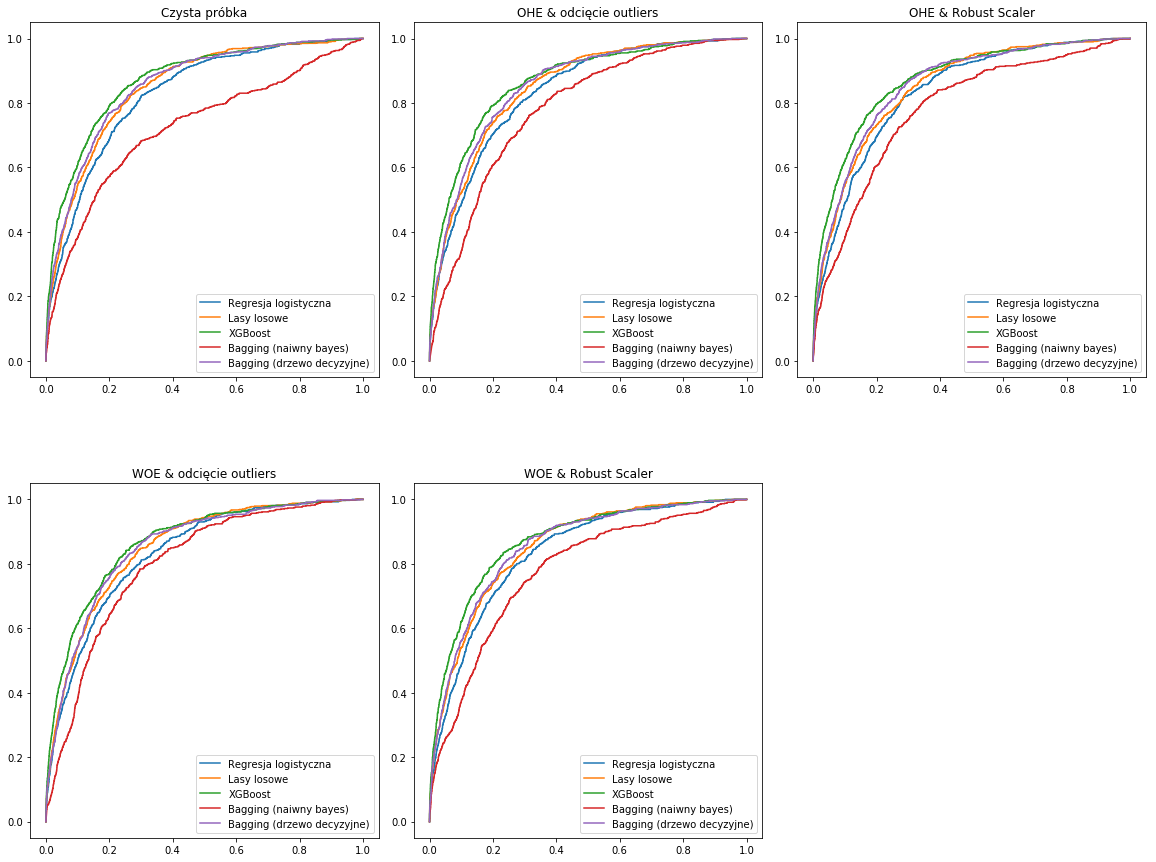

In [49]:
fig = plt.figure(figsize=(20,15))
for i, zbior_test in enumerate(zbiory_testowy):
    ax = fig.add_subplot(2,3,i+1)
    ax.set_title(opisy[i])
    for j,nazwa in enumerate(nazwy):
        y_pred_proba=best_estimators[i*5+j].predict_proba(zbior_test)[:,1]
        fpr,tpr, _=roc_curve(y_true=y_test,y_score=y_pred_proba)
        plt.plot(fpr,tpr,label=nazwa)
    plt.legend(loc=4)
plt.subplots_adjust(hspace = 0.3, wspace = 0.1)
plt.show()                


###### Podsumowanie

Na podstawie powyższych wyników można dojść do wielu ciekawych wniosków. 

Zaczynając od porównania próbek, można łatwo zauważyć, że dla każdego modelu oprócz Baggingu przy użyciu naiwnego Bayesa, przygotowanie próbki nie miało w tym przypadku większego znaczenia. Oznacza to, że wykorzystane w tym projekcie modele całkiem dobrze poradziły sobie z wartościami odstającymi i nadmiarem zmiennych. Ewentualnie w przypadku regresji logistycznej delikatnie lepszym rozwiązaniem okazało się użycie robust scalera niż odcięcie outliersów. Natomiast w przypadku Baggingu przy użyciu naiwnego Bayesa przygotowanie próbki testowej miało ogromne znaczenie. Dla próbki najmniej oczyszczonej wynik wyniósł zaledwie 6% maksymalnego zysku, ale patrząc również na pozostałe parametry jest to bardzo słaby rezultat - accuracy poniżej 16% oraz F1 poniżej 9%. W tym przypadku najlepiej sprawdziło się użycie robust scalera (ponad 30% maksymalnego zysku), gorzej odcięcie outliersów (około 16% maksymalnego zysku)

Najlepszym modelem okazał się XGBoost gdzie miara potencjalnego zysku wyniosła ponad 57% na zbiorze testowym. Również pozostałe parametry są na całkeim dobrym poziomie - AUC ponad 87%, accuracy 83%. Jednak przyglądając się również wynikom na zbiorze treningowym, można zauważyć ryzyko overfittingu. Można je ograniczyć zmniejszając np. parametr max_depth do 5, jednak wtedy otrzymamy dużo gorsze wyniki (accuracy spada do poziomu nawet 70%).

Kolejnymi jeśli chodzi o miarę potencjalgeo zysku są modele: Bagging wykorzystujący drzewa decyzyjne i lasy losowe. Oba opierają się na drzewach decyzyjnych więc nie dziwi to, że dają podobne wyniki. Również w ich przypadku widoczny jest spadek wyników na zbiorze testowym w porównaniu do zbioru treningowego, ale nie jest on tak duży jak w przypadku XGBoosta. 

Regresja logistyczne nie daje wcale aż tak mocno odbiegających wyników, a jest dużo bardziej stabilna - wyniki na zbiorze treningowych i testowym są prawie tożsame.

## ROZDZIAŁ 8 - SELEKCJA ZMIENNYCH <a class="anchor" id="#rozdz8"></a>

Zagadnienie wyboru odpowiedni cech ma bardzo duże znaczenie zwłaszcza w przypadku przetwarzania ogromnej ilości danych. Redukcja ilości zmiennych (wymiarów) może zdecydowanie przyspieszyć wykonywanie obliczeń. Dodatkwo gdy mamy do czynienia z dużą ilością zmiennych jest ryzyko, że model utknie w lokalnym optimum lub dopasuje się do szumu z powodu korelacji między zmiennymi.

Jest dużo różnych technik selekcji zmiennych (źródło:`A. Boschetti, L.Massaron, Python Podstawy nauki o danych, wydanie II, Helion)`:
* wybór na podstawie wariancji
* wybór jednoczynnikowy
* rekurencyjna eliminacja
* wybór na podstawie regularyzacji L1 (zastosowany we wcześniejszym rozdziale)
* wybór na podstawie drzew
* wybór ekspercki
* zastosowanie algorytmów do redukcji wymiarów (PCA)

W niniejszym projekcie użyto klasy `SelectKBest`, rekurencyjnej eliminacji (`REFCV`) oraz selekcji na podstawie wcześniej przeprowadzonych analiz. Pamiętajmy również, że w przypadku regresji logistycznej użyliśmy regularyzacji z normą L1.
By ograniczyć ilość przetwarzań, selekcję zmiennych dokonujemy tylko na jednej próbce - dla danych kategorycznych użyta metoda WOE, dla numerycznych robust scaler. Dla przypomnienia sprawdzimy ile zmiennych posiada próbka:

In [50]:
X_train_WOE_ROBUST.shape

(63324, 54)

###### SelectKBest

Dla każdego modelu opisanego w [rozdziale 5](#rozdz5) postaramy się znowu dobrać odpowiednie hiperparametry, ale po wcześniejszym wybraniu odpowiedniej liczby najlepszych zmiennych. Oczywiście nie wiemy jaka to jest liczba, dlatego będzie ona jednym z parametrów GridSearchCV. Próbka ma 54 zmienne, więc maksymalną liczbą zmiennych ustawimy na 50.

In [51]:
nazwy = ["Regresja logistyczna", "Lasy losowe", "XGBoost", "Bagging (naiwny bayes)", "Bagging (drzewo decyzyjne)"]

modele=[
    [("selector",SelectKBest(score_func=f_classif)),("model", LogisticRegression())],
    [("selector",SelectKBest(score_func=f_classif)),("model", RandomForestClassifier())],
    [("selector",SelectKBest(score_func=f_classif)),("model", XGBClassifier())],
    [("selector",SelectKBest(score_func=f_classif)),("model", BaggingClassifier(base_estimator=GaussianNB()))],
    [("selector",SelectKBest(score_func=f_classif)),("model", BaggingClassifier(base_estimator=DecisionTreeClassifier()))]]


parametry = [{"selector__k":[10,20,30,40,50],"model__C":[0.1,0.01,1],
              "model__class_weight":[{0:1,1:1},{0:1,1:20},{0:1,1:30}{0:1,1:40}],"model__penalty":["l1","l2"]},
             {"selector__k":[10,20,30,40,50],"model__n_estimators":[20,50,100], "model__max_depth":[10,5],
              "model__class_weight":[{0:1,1:1},{0:1,1:20},{0:1,1:30}], 'model__min_samples_split':[10,20],
              'model__min_samples_leaf':[10,20]},
             {"selector__k":[10,20,30,40,50],"model__scale_pos_weight":[40,30,1],"model__n_estimators":[200,100],
              "model__max_depth":[5,10],"model__gamma":[50,100],"model__colsample_bytree":[0.7,1],
              "model__min_child_weight":[100,50], "model__subsample":[0.7,1]},
             {"selector__k":[10,20,30,40,50],'model__n_estimators':[20,50,100],'model__max_samples':[0.3,0.7,1.0],
              'model__max_features':[0.3,0.7,1.0]},
             {"selector__k":[10,20,30,40,50],'model__base_estimator__min_samples_split':[10,20],
              'model__base_estimator__min_samples_leaf':[10,50],'model__base_estimator__max_depth':[5,10],
              "model__base_estimator__class_weight":[{0:1,1:1},{0:1,1:40}, {0:1,1:20}],'model__n_estimators':[100, 50],
              'model__max_samples':[0.7,1.0],'model__max_features':[0.7,1.0]}]


accuracy_train_s = []
accuracy_test_s = []
auc_train_s = []
auc_test_s = []
f1_train_s = []
f1_test_s = []
pot_profit_train_s = []
pot_profit_test_s = []
false_positive_s = []
false_negative_s = []
recall_s = []
precision_s = []
k_number_s = []

for nazwa, model, parametr in zip(nazwy, modele, parametry):
    print("*****************************************************")
    print(f"Obecnie wykonuje się model: {nazwa}")
    print("*****************************************************")
    potok=Pipeline(model)
    optymalny_model=GridSearchCV(potok, parametr, cv=3, scoring=potent_profit_score)
    optymalny_model.fit(X_train_WOE_ROBUST,y_train)
    k_number_s.append(optymalny_model.best_estimator_.steps[0][1].get_params()['k'])
    accuracy_train_s.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(X_train_WOE_ROBUST),y_true=y_train))
    accuracy_test_s.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST),y_true=y_test))
    auc_train_s.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(X_train_WOE_ROBUST)[:,1],y_true=y_train))
    auc_test_s.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(X_test_WOE_ROBUST)[:,1],y_true=y_test))
    f1_train_s.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(X_train_WOE_ROBUST),y_true=y_train))
    f1_test_s.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST),y_true=y_test))
    pot_profit_train_s.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(X_train_WOE_ROBUST),y_true=y_train))
    pot_profit_test_s.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST),y_true=y_test))
    FP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST) == 1, y_test == 0))
    TP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST) == 1, y_test == 1))
    FN=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST) == 0, y_test == 1))
    false_positive_s.append(FP)
    false_negative_s.append(FN)
    recall_s.append(TP/(TP+FN))
    precision_s.append(TP/(TP+FP))

*****************************************************
Obecnie wykonuje się model: Regresja logistyczna
*****************************************************
*****************************************************
Obecnie wykonuje się model: Lasy losowe
*****************************************************
*****************************************************
Obecnie wykonuje się model: XGBoost
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (naiwny bayes)
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (drzewo decyzyjne)
*****************************************************


In [52]:
podsumowanie_s=pd.DataFrame({"Acc_train":accuracy_train_s, "Acc_test":accuracy_test_s,
                           "AUC_train":auc_train_s, "AUC_test":auc_test_s,
                           "F1_train":f1_train_s, "F1_test":f1_test_s, 
                           "Pot_profit_train":pot_profit_train_s, "Pot_profit_test":pot_profit_test_s,
                           "false_positive": false_positive_s,"false_negative": false_negative_s,
                           "recall":recall_s, "precision":precision_s, "Ilość zmiennych":k_number_s}, index=nazwy)
podsumowanie_s

,AUC_test,AUC_train,Acc_test,Acc_train,F1_test,F1_train,Ilość zmiennych,Pot_profit_test,Pot_profit_train,false_negative,false_positive,precision,recall
Regresja logistyczna,0.832848,0.828918,0.683595,0.686770,0.183271,0.182096,50,0.507509,0.497221,110,4899,0.102912,0.836310
Lasy losowe,0.848631,0.912089,0.769503,0.779704,0.219799,0.251529,40,0.526508,0.644360,158,3491,0.128340,0.764881
XGBoost,0.867432,0.980176,0.831723,0.858363,0.271335,0.374241,50,0.564967,0.850987,176,2488,0.166220,0.738095
Bagging (naiwny bayes),0.787809,0.782807,0.924768,0.925731,0.209688,0.225334,50,0.164171,0.185475,514,677,0.189222,0.235119
Bagging (drzewo decyzyjne),0.853756,0.919367,0.809046,0.823369,0.247823,0.290517,50,0.544231,0.670069,174,2849,0.148790,0.741071


###### Podsumowanie





GridSearch w każdym przypadku oprócz jednego wybrał, że najlepsze wyniki są przy użyciu conajmniej 50 parametrów. Dodatkowo można zauważyć, że ostateczne wyniki nie uległy poprawie, wręcz przeciwnie, w przypadku Baggingu przy użyciu naiwnego Bayesa widoczny jest spory spadek. 

Jednak metoda KBest sprawdza się w przypadku gdy z góry wiemy do ilu zmiennych chcemy zejść w naszej redukcji. Np. zależy nam na przyspieszeniu kalkulacji, albo mamy ograniczoną moc obliczeniową i chcemy pracować na 20 lub nawet 10 zmiennych, wtedy możemy wybrać je za pomocą właśnie KBest. Takie ćwiczenie wykonałem poniżej. Otrzymane wyniki wskazują, że przy redukcji do 20 zmiennych wyniki są słabsze, ale jeszcze bardzo zbliżone do tych uzyskanych przy użyciu wszystkich zmiennych. Jednak redukcja do 10 zmiennych już bardzo mocno obniża ostateczny wynik modeli. Więcej szczegółów poniżej

Nie zapominajmy, że do samej redukcji wymiarów służą również innej metody np. PCA, jednak powodują one transormację pierwotnych danych, co może bardzo zaburzyć interpretację wyników.

In [53]:
nazwy = ["Regresja logistyczna", "Lasy losowe", "XGBoost", "Bagging (naiwny bayes)", "Bagging (drzewo decyzyjne)"]

modele=[
    [("selector",SelectKBest(score_func=f_classif)),("model", LogisticRegression())],
    [("selector",SelectKBest(score_func=f_classif)),("model", RandomForestClassifier())],
    [("selector",SelectKBest(score_func=f_classif)),("model", XGBClassifier())],
    [("selector",SelectKBest(score_func=f_classif)),("model", BaggingClassifier(base_estimator=GaussianNB()))],
    [("selector",SelectKBest(score_func=f_classif)),("model", BaggingClassifier(base_estimator=DecisionTreeClassifier()))]]



parametry = [{"selector__k":[20],"model__C":[0.1,0.01,1],
              "model__class_weight":[{0:1,1:1},{0:1,1:20},{0:1,1:30}{0:1,1:40}],"model__penalty":["l1","l2"]},
             {"selector__k":[20],"model__n_estimators":[20,50,100], "model__max_depth":[10,5],
              "model__class_weight":[{0:1,1:1},{0:1,1:20},{0:1,1:30}], 'model__min_samples_split':[10,20],
              'model__min_samples_leaf':[10,20]},
             {"selector__k":[20],"model__scale_pos_weight":[40,30,1],"model__n_estimators":[200,100],
              "model__max_depth":[5,10],"model__gamma":[50,100],"model__colsample_bytree":[0.7,1],
              "model__min_child_weight":[100,50], "model__subsample":[0.7,1]},
             {"selector__k":[20],'model__n_estimators':[20,50,100],'model__max_samples':[0.3,0.7,1.0],
              'model__max_features':[0.3,0.7,1.0]},
             {"selector__k":[20],'model__base_estimator__min_samples_split':[10,20],
              'model__base_estimator__min_samples_leaf':[10,50],'model__base_estimator__max_depth':[5,10],
              "model__base_estimator__class_weight":[{0:1,1:1},{0:1,1:40}, {0:1,1:20}],'model__n_estimators':[100, 50],
              'model__max_samples':[0.7,1.0],'model__max_features':[0.7,1.0]}]



accuracy_train_s = []
accuracy_test_s = []
auc_train_s = []
auc_test_s = []
f1_train_s = []
f1_test_s = []
pot_profit_train_s = []
pot_profit_test_s = []
false_positive_s = []
false_negative_s = []
recall_s = []
precision_s = []
k_number_s = []

for nazwa, model, parametr in zip(nazwy, modele, parametry):
    print("*****************************************************")
    print(f"Obecnie wykonuje się model: {nazwa}")
    print("*****************************************************")
    potok=Pipeline(model)
    optymalny_model=GridSearchCV(potok, parametr, cv=3, scoring=potent_profit_score)
    optymalny_model.fit(X_train_WOE_ROBUST,y_train)
    k_number_s.append(optymalny_model.best_estimator_.steps[0][1].get_params()['k'])
    accuracy_train_s.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(X_train_WOE_ROBUST),y_true=y_train))
    accuracy_test_s.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST),y_true=y_test))
    auc_train_s.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(X_train_WOE_ROBUST)[:,1],y_true=y_train))
    auc_test_s.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(X_test_WOE_ROBUST)[:,1],y_true=y_test))
    f1_train_s.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(X_train_WOE_ROBUST),y_true=y_train))
    f1_test_s.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST),y_true=y_test))
    pot_profit_train_s.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(X_train_WOE_ROBUST),y_true=y_train))
    pot_profit_test_s.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST),y_true=y_test))
    FP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST) == 1, y_test == 0))
    TP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST) == 1, y_test == 1))
    FN=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST) == 0, y_test == 1))
    false_positive_s.append(FP)
    false_negative_s.append(FN)
    recall_s.append(TP/(TP+FN))
    precision_s.append(TP/(TP+FP))

*****************************************************
Obecnie wykonuje się model: Regresja logistyczna
*****************************************************
*****************************************************
Obecnie wykonuje się model: Lasy losowe
*****************************************************
*****************************************************
Obecnie wykonuje się model: XGBoost
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (naiwny bayes)
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (drzewo decyzyjne)
*****************************************************


In [54]:
podsumowanie_s=pd.DataFrame({"Acc_train":accuracy_train_s, "Acc_test":accuracy_test_s,
                           "AUC_train":auc_train_s, "AUC_test":auc_test_s,
                           "F1_train":f1_train_s, "F1_test":f1_test_s, 
                           "Pot_profit_train":pot_profit_train_s, "Pot_profit_test":pot_profit_test_s,
                           "false_positive": false_positive_s,"false_negative": false_negative_s,
                           "recall":recall_s, "precision":precision_s, "Ilość zmiennych":k_number_s}, index=nazwy)
podsumowanie_s

,AUC_test,AUC_train,Acc_test,Acc_train,F1_test,F1_train,Ilość zmiennych,Pot_profit_test,Pot_profit_train,false_negative,false_positive,precision,recall
Regresja logistyczna,0.818850,0.813804,0.674247,0.677595,0.177905,0.176043,20,0.491853,0.477696,114,5043,0.099625,0.830357
Lasy losowe,0.828630,0.855945,0.707346,0.713047,0.189893,0.196365,20,0.504321,0.529082,129,4504,0.107589,0.808036
XGBoost,0.835863,0.898678,0.682269,0.691507,0.185293,0.204504,20,0.520857,0.613763,100,4930,0.103962,0.851190
Bagging (naiwny bayes),0.800166,0.797090,0.943213,0.945424,0.213473,0.238095,20,0.130396,0.153004,550,349,0.259023,0.181548
Bagging (drzewo decyzyjne),0.828325,0.860470,0.707599,0.713252,0.190310,0.199947,20,0.506058,0.547343,128,4501,0.107830,0.809524


In [55]:
nazwy = ["Regresja logistyczna", "Lasy losowe", "XGBoost", "Bagging (naiwny bayes)", "Bagging (drzewo decyzyjne)"]

modele=[
    [("selector",SelectKBest(score_func=f_classif)),("model", LogisticRegression())],
    [("selector",SelectKBest(score_func=f_classif)),("model", RandomForestClassifier())],
    [("selector",SelectKBest(score_func=f_classif)),("model", XGBClassifier())],
    [("selector",SelectKBest(score_func=f_classif)),("model", BaggingClassifier(base_estimator=GaussianNB()))],
    [("selector",SelectKBest(score_func=f_classif)),("model", BaggingClassifier(base_estimator=DecisionTreeClassifier()))]]





parametry = [{"selector__k":[10],"model__C":[0.1,0.01,1],
              "model__class_weight":[{0:1,1:1},{0:1,1:20},{0:1,1:30}{0:1,1:40}],"model__penalty":["l1","l2"]},
             {"selector__k":[10],"model__n_estimators":[20,50,100], "model__max_depth":[10,5],
              "model__class_weight":[{0:1,1:1},{0:1,1:20},{0:1,1:30}], 'model__min_samples_split':[10,20],
              'model__min_samples_leaf':[10,20]},
             {"selector__k":[10],"model__scale_pos_weight":[40,30,1],"model__n_estimators":[200,100],
              "model__max_depth":[5,10],"model__gamma":[50,100],"model__colsample_bytree":[0.7,1],
              "model__min_child_weight":[100,50], "model__subsample":[0.7,1]},
             {"selector__k":[10],'model__n_estimators':[20,50,100],'model__max_samples':[0.3,0.7,1.0],
              'model__max_features':[0.3,0.7,1.0]},
             {"selector__k":[10],'model__base_estimator__min_samples_split':[10,20],
              'model__base_estimator__min_samples_leaf':[10,50],'model__base_estimator__max_depth':[5,10],
              "model__base_estimator__class_weight":[{0:1,1:1},{0:1,1:40}, {0:1,1:20}],'model__n_estimators':[100, 50],
              'model__max_samples':[0.7,1.0],'model__max_features':[0.7,1.0]}]





accuracy_train_s = []
accuracy_test_s = []
auc_train_s = []
auc_test_s = []
f1_train_s = []
f1_test_s = []
pot_profit_train_s = []
pot_profit_test_s = []
false_positive_s = []
false_negative_s = []
recall_s = []
precision_s = []
k_number_s = []

for nazwa, model, parametr in zip(nazwy, modele, parametry):
    print("*****************************************************")
    print(f"Obecnie wykonuje się model: {nazwa}")
    print("*****************************************************")
    potok=Pipeline(model)
    optymalny_model=GridSearchCV(potok, parametr, cv=3, scoring=potent_profit_score)
    optymalny_model.fit(X_train_WOE_ROBUST,y_train)
    k_number_s.append(optymalny_model.best_estimator_.steps[0][1].get_params()['k'])
    accuracy_train_s.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(X_train_WOE_ROBUST),y_true=y_train))
    accuracy_test_s.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST),y_true=y_test))
    auc_train_s.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(X_train_WOE_ROBUST)[:,1],y_true=y_train))
    auc_test_s.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(X_test_WOE_ROBUST)[:,1],y_true=y_test))
    f1_train_s.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(X_train_WOE_ROBUST),y_true=y_train))
    f1_test_s.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST),y_true=y_test))
    pot_profit_train_s.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(X_train_WOE_ROBUST),y_true=y_train))
    pot_profit_test_s.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST),y_true=y_test))
    FP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST) == 1, y_test == 0))
    TP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST) == 1, y_test == 1))
    FN=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_WOE_ROBUST) == 0, y_test == 1))
    false_positive_s.append(FP)
    false_negative_s.append(FN)
    recall_s.append(TP/(TP+FN))
    precision_s.append(TP/(TP+FP))

*****************************************************
Obecnie wykonuje się model: Regresja logistyczna
*****************************************************
*****************************************************
Obecnie wykonuje się model: Lasy losowe
*****************************************************
*****************************************************
Obecnie wykonuje się model: XGBoost
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (naiwny bayes)
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (drzewo decyzyjne)
*****************************************************


In [56]:
podsumowanie_s=pd.DataFrame({"Acc_train":accuracy_train_s, "Acc_test":accuracy_test_s,
                           "AUC_train":auc_train_s, "AUC_test":auc_test_s,
                           "F1_train":f1_train_s, "F1_test":f1_test_s, 
                           "Pot_profit_train":pot_profit_train_s, "Pot_profit_test":pot_profit_test_s,
                           "false_positive": false_positive_s,"false_negative": false_negative_s,
                           "recall":recall_s, "precision":precision_s, "Ilość zmiennych":k_number_s}, index=nazwy)
podsumowanie_s

,AUC_test,AUC_train,Acc_test,Acc_train,F1_test,F1_train,Ilość zmiennych,Pot_profit_test,Pot_profit_train,false_negative,false_positive,precision,recall
Regresja logistyczna,0.761030,0.759060,0.642600,0.651570,0.150960,0.150797,10,0.377773,0.368756,169,5489,0.083945,0.748512
Lasy losowe,0.763169,0.763338,0.699514,0.708136,0.164119,0.166276,10,0.384172,0.385104,205,4552,0.093046,0.694940
XGBoost,0.763415,0.762383,0.575074,0.575895,0.137232,0.135518,10,0.354399,0.343503,137,6590,0.075088,0.796131
Bagging (naiwny bayes),0.760166,0.758851,0.942960,0.944050,0.215465,0.238228,10,0.133078,0.156725,548,355,0.258873,0.184524
Bagging (drzewo decyzyjne),0.760491,0.761430,0.642600,0.651570,0.150960,0.150797,10,0.377773,0.368756,169,5489,0.083945,0.748512


###### RFECV

W przypadku selekcji jednoczynnikowych może okazać się, że na potrzeby wybranych algorytmów dalej taki podzbiór będzie zawierał nadmiarowe infomacje. Z kolei w otrzymaniu zbioru, który będzie pozbawiony takich informacji przydatna może okazać się rekurencyjna eliminacja. Na podstawie tej samej próbki co w przypafku selectora KBest, dla każdego modelu (oprócz Baggingu, ze względu na brak kompatybilnosci z RFECV) wraz z najlepszymi hiperparametrami z [rozdziału 7], przeprowadzimy eliminację rekurencyjną. Tym samym postaramy się uzyskać jeszcze lepsze wyniki.

In [57]:
modele=[]
for i in range(20,23):
    modele.append(best_estimators[i].steps[0][1]) #pobieram najlepsze parametry modeli z próbki WOE&Robust
nazwy= ["Regresja logistyczna", "Lasy losowe", "XGBoost"]

accuracy_train_r = []
accuracy_test_r = []
auc_train_r = []
auc_test_r = []
f1_train_r = []
f1_test_r = []
pot_profit_train_r = []
pot_profit_test_r = []
false_positive_r = []
false_negative_r = []
recall_r = []
precision_r = []
n_features_r = []

for model, nazwa in zip(modele,nazwy):
    print(nazwa)
    selector_rfe=RFECV(model,step=0.05, scoring=potent_profit_score,cv=3)
    print("Fituje RFECV")
    selector_rfe.fit(X_train_WOE_ROBUST,y_train) 
    X_train_rfe=selector_rfe.transform(X_train_WOE_ROBUST)
    X_test_rfe=selector_rfe.transform(X_test_WOE_ROBUST)
    n_features_r.append(selector_rfe.n_features_)
    print("licze docelowy model")
    model.fit(X_train_rfe,y_train)
    accuracy_train_r.append(accuracy_score(y_pred=model.predict(X_train_rfe),y_true=y_train))
    accuracy_test_r.append(accuracy_score(y_pred=model.predict(X_test_rfe),y_true=y_test))
    auc_train_r.append(roc_auc_score(y_score=model.predict_proba(X_train_rfe)[:,1],y_true=y_train))
    auc_test_r.append(roc_auc_score(y_score=model.predict_proba(X_test_rfe)[:,1],y_true=y_test))
    f1_train_r.append(f1_score(y_pred=model.predict(X_train_rfe),y_true=y_train))
    f1_test_r.append(f1_score(y_pred=model.predict(X_test_rfe),y_true=y_test))
    pot_profit_train_r.append(potencjalny_zysk_score(y_pred=model.predict(X_train_rfe),y_true=y_train))
    pot_profit_test_r.append(potencjalny_zysk_score(y_pred=model.predict(X_test_rfe),y_true=y_test))
    FP=np.sum(np.logical_and(model.predict(X_test_rfe) == 1, y_test == 0))
    TP=np.sum(np.logical_and(model.predict(X_test_rfe) == 1, y_test == 1))
    FN=np.sum(np.logical_and(model.predict(X_test_rfe) == 0, y_test == 1))
    false_positive_r.append(FP)
    false_negative_r.append(FN)
    recall_r.append(TP/(TP+FN))
    precision_r.append(TP/(TP+FP))
 

Regresja logistyczna
Fituje RFECV
licze docelowy model
Lasy losowe
Fituje RFECV
licze docelowy model
XGBoost
Fituje RFECV
licze docelowy model


In [58]:
podsumowanie_r=pd.DataFrame({"Acc_train":accuracy_train_r, "Acc_test":accuracy_test_r,
                           "AUC_train":auc_train_r, "AUC_test":auc_test_r,
                           "F1_train":f1_train_r, "F1_test":f1_test_r, 
                           "Pot_profit_train":pot_profit_train_r, "Pot_profit_test":pot_profit_test_r,
                           "false_positive": false_positive_r,"false_negative": false_negative_r,
                           "recall":recall_r, "precision":precision_r,"Ilosc zmiennych":n_features_r},index=nazwy)
podsumowanie_r

,AUC_test,AUC_train,Acc_test,Acc_train,F1_test,F1_train,Ilosc zmiennych,Pot_profit_test,Pot_profit_train,false_negative,false_positive,precision,recall
Regresja logistyczna,0.833370,0.829092,0.684038,0.686912,0.183480,0.181826,36,0.507971,0.495528,110,4892,0.103044,0.836310
Lasy losowe,0.852229,0.923515,0.785295,0.799823,0.229426,0.271243,44,0.531214,0.670894,166,3233,0.135330,0.752976
XGBoost,0.870269,0.980938,0.835702,0.861727,0.276897,0.379799,54,0.572069,0.854131,174,2427,0.170256,0.741071


###### Podsumowanie

W tym przypadku łatwo zauważyć, że metoda RFECV spowodowała, że ograniczyliśmy liczbę wymiarów, nie powodując spadku wyniku. Co prawda liczyliśmy, że redukcja spowoduje poprawienie wyniku, jednak przy użytych modelach nie jest to widoczne. Wynika to z faktu, że w przypadku regresji logistycznej użyliśmy regularyzacji normą L1, która całkiem dobrze poradziła sobie z nadmiarem informacji. Z kolei metody wykorzystujące drzewa decyzyjne zazwyczaj radzą sobie z nadmiarem zmiennych - nieraz lasy losowe są wykorzystywane właśnie do rozpoznawania istotnych cech (jak zostało opisane na początku tego [rozdziału](#rozdz8))

###### Selekcja zmiennych na podstawie wczesniejszych analiz

Dokonamy teraz selekcji eksperckiej, na podstawie analiz z [rozdziału 3](#rozdz3). Z wartości numerycznych wybrane zostanie jedynie `DPD_FALL_IN_12M` ponieważ rozkład dla obserwacji z flagą default znacząco różni się od rozkład dla obserwacji bez tej flagi. Więcej szczegółów na temat nowych zmiennych jak i analiz dla pozostałych zmiennych znajduje się w [rozdziale 3](#rozdz3)

In [59]:
#wybranie zmiennych numerycznych
numeric_list_select=['DPD_FALL_IN_12M']

In [60]:
#wybranie zmiennych kategorycznych
woe_list_select=['AGE_BANDS', 'EDUCATION', 'MARITAL_STATUS', 'OWNERSHIP', 'EMP_TYPE']

In [61]:
#Stworzenie odpowiedniego pipeline

pipe_selekcja=FeatureUnion([
    ("tekstowe_woe", make_pipeline(TransformerFeature(woe_list_select),
                              TransformerLowCat(woe_list_select),
                              TransformerWOE(woe_list_select))),
    ("numeryczne", make_pipeline(TransformerFeature(numeric_list_select),
                                 TransformerOutliers(numeric_list_select),
                                 SimpleImputer(strategy="median"),
                                 StandardScaler())),
    ("numeryczne_nowe", make_pipeline(TransformerFeature(['DUE_AMOUNT','DPD','DPD_FALL_IN_12M','NO_INFLOWS','INCOME_3M',
                                                          'SAVING_BALANCE']),
                                      TransformerNew(['DUE_AMOUNT','SAVING_BALANCE','NO_INFLOWS']),
                                      TransformerNewDPD(['DPD']),
                                      TransformerNewFeatNonNuLL(['INCOME_3M']),
                                      TransformerNewDPD12M(['DPD_FALL_IN_12M'])))
])

X_train_select=X_train.copy()
X_train_select=pd.DataFrame(pipe_selekcja.fit_transform(X_train_select,y_train))
X_test_select=X_test.copy()
X_test_select=pd.DataFrame(pipe_selekcja.transform(X_test_select))


In [62]:
nazwy= ["Regresja logistyczna", "Lasy losowe", "XGBoost", "Bagging (naiwny bayes)", "Bagging (drzewo decyzyjne)"]

modele=[
    [("model", LogisticRegression())],
    [("model", RandomForestClassifier())],
    [("model", XGBClassifier())],
    [("model", BaggingClassifier(base_estimator=GaussianNB()))],
    [("model", BaggingClassifier(base_estimator=DecisionTreeClassifier()))]]


parametry = [{"model__C":[0.1,0.01,1],"model__class_weight":[{0:1,1:1},{0:1,1:20},{0:1,1:30}{0:1,1:40}],
              "model__penalty":["l1","l2"]},
             {"model__n_estimators":[20,50,100], "model__max_depth":[10,5],
              "model__class_weight":[{0:1,1:1},{0:1,1:20},{0:1,1:30}], 'model__min_samples_split':[10,20],
              'model__min_samples_leaf':[10,20]},
             {"model__scale_pos_weight":[40,30,1],"model__n_estimators":[200,100], "model__max_depth":[5,10],
              "model__gamma":[50,100],
              "model__colsample_bytree":[0.7,1], "model__min_child_weight":[100,50], "model__subsample":[0.7,1]},
             {'model__n_estimators':[20,50,100],'model__max_samples':[0.3,0.7,1.0],'model__max_features':[0.3,0.7,1.0]},
             {'model__base_estimator__min_samples_split':[10,20], 'model__base_estimator__min_samples_leaf':[10,50],
              'model__base_estimator__max_depth':[5,10],
              "model__base_estimator__class_weight":[{0:1,1:1},{0:1,1:40}, {0:1,1:20}],
              'model__n_estimators':[100, 50],'model__max_samples':[0.7,1.0],'model__max_features':[0.7,1.0]}]


accuracy_train_se = []
accuracy_test_se = []
auc_train_se = []
auc_test_se = []
f1_train_se = []
f1_test_se = []
pot_profit_train_se = []
pot_profit_test_se = []
false_positive_se = []
false_negative_se = []
recall_se = []
precision_se = []


for nazwa, model, parametr in zip(nazwy, modele, parametry):
    print("*****************************************************")
    print(f"Obecnie wykonuje się model: {nazwa}")
    print("*****************************************************")
    potok=Pipeline(model)
    optymalny_model=GridSearchCV(potok, parametr, cv=3, scoring=potent_profit_score)
    optymalny_model.fit(X_train_select,y_train)
        
    accuracy_train_se.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(X_train_select),y_true=y_train))
    accuracy_test_se.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(X_test_select),y_true=y_test))
    auc_train_se.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(X_train_select)[:,1],y_true=y_train))
    auc_test_se.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(X_test_select)[:,1],y_true=y_test))
    f1_train_se.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(X_train_select),y_true=y_train))
    f1_test_se.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(X_test_select),y_true=y_test))
    pot_profit_train_se.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(X_train_select),y_true=y_train))
    pot_profit_test_se.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(X_test_select),y_true=y_test))
    FP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_select) == 1, y_test == 0))
    TP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_select) == 1, y_test == 1))
    FN=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(X_test_select) == 0, y_test == 1))
    false_positive_se.append(FP)
    false_negative_se.append(FN)
    recall_se.append(TP/(TP+FN))
    precision_se.append(TP/(TP+FP))


*****************************************************
Obecnie wykonuje się model: Regresja logistyczna
*****************************************************
*****************************************************
Obecnie wykonuje się model: Lasy losowe
*****************************************************
*****************************************************
Obecnie wykonuje się model: XGBoost
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (naiwny bayes)
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (drzewo decyzyjne)
*****************************************************


In [63]:
podsumowanie_se=pd.DataFrame({"Acc_train":accuracy_train_se, "Acc_test":accuracy_test_se,
                           "AUC_train":auc_train_se, "AUC_test":auc_test_se,
                           "F1_train":f1_train_se, "F1_test":f1_test_se, 
                           "Pot_profit_train":pot_profit_train_se, "Pot_profit_test":pot_profit_test_se,
                           "false_positive": false_positive_se,"false_negative": false_negative_se,
                           "recall":recall_se, "precision":precision_se},index=nazwy)
podsumowanie_se

,AUC_test,AUC_train,Acc_test,Acc_train,F1_test,F1_train,Pot_profit_test,Pot_profit_train,false_negative,false_positive,precision,recall
Regresja logistyczna,0.798935,0.795679,0.640958,0.644763,0.161899,0.159976,0.443829,0.429047,123,5561,0.089853,0.816964
Lasy losowe,0.804813,0.831111,0.672857,0.679237,0.170431,0.179114,0.452097,0.492301,140,5039,0.095495,0.791667
XGBoost,0.802215,0.840621,0.604257,0.606405,0.151888,0.161655,0.423181,0.485117,111,6154,0.083544,0.834821
Bagging (naiwny bayes),0.792137,0.787147,0.916367,0.919241,0.203369,0.234660,0.171603,0.215527,503,821,0.170707,0.251488
Bagging (drzewo decyzyjne),0.803535,0.828447,0.586444,0.588466,0.151173,0.154445,0.436990,0.457912,89,6458,0.082801,0.867560


###### Podsumowanie

Selekcja ekspercka ograniczyła liczbę zmiennych do zaledwie 12. Jest to ogromna redukcja wymiarów, biorąc pod uwagę możliwosći obliczeniowe i tym samym skraca czas dalszych przetwarzań. Niestety wynik uległ pogorszeniu, ale nie jest ono, aż tak drastyczne. Dużo zależy od tego co dla nas jest ważne i czy redukcja wymiarów i przyspieszenie obliczeń rekompensuje pogorszenie wyniku. 

Co ciekawe, można zauważyć, że w tym przypadku otrzymane w ten sposób modele są bardziej konserwatywne - zazwyczaj charakteryzują się większą czułością, ale też dużo gorszą precyzją.

## ROZDZIAŁ 9 - PROBLEM NIEZBALANSOWANEJ PRÓBY <a class="anchor" id="#rozdz9"></a>

Jak już zostało wspomniane w [rozdziale 7](#rozdz7), problem niezbalansowanej próby został już poniekąd zaadresowany za pomocą odpowiednich hiperparametrów dotyczących wag dla poszczególnych klas. Metod radzenia sobie z tym problemem jest zdecydowanie więcej. W niniejszym projekcie, mając na celu porównanie wyników przy użyciu różnych metod, użyję jeszcze jednej metody, która tak naprawdę jest jedną z najbardziej podstawowych metod - Oversampling. Na podstawie próbki WOE&Robust zostaną stworzone 4 nowe próbki w następujący sposób:
* do każdej próbki zostaną dolosowane dodatkowe obserwacje z flagą default (odpowiednio 100 000, 60 000, 30 000 i 10 000 obserwacji)
* zmianie ulegnie oczywiście zarówno zbiór trenningowy X jak i y
* na każdej próbce zostaną znowu dobrane najlepsze parametry, tym razem już bez parametru odpowiedzialnego za wagi klas.

In [64]:
listka=[x for x in range(63324)]#zmieniam indeksy by łatwiej połączyć z zbiorem treningowych
y_train.index=listka

In [69]:
licznosci=[100000,60000,30000,10000]
oversamples_x=[]
oversamples_y=[]
zbior_trening=X_train_WOE_ROBUST
zbior_test=X_test_WOE_ROBUST

for licz in licznosci:
    x_train_oversample=pd.concat([zbior_trening[y_train==0],zbior_trening[y_train==1].sample(licz,replace=True)])
    y_train_oversample=np.concatenate([np.repeat(0,np.sum(y_train==0)),np.repeat(1,licz)])
    oversamples_x.append(x_train_oversample)
    oversamples_y.append(y_train_oversample)
    
opisy=["Dolosowane 100 000", "Dolosowane 60 000", "Dolosowane 30 000", "Dolosowane 10 000"]

nazwy= ["Regresja logistyczna", "Lasy losowe", "XGBoost", "Bagging (naiwny bayes)", "Bagging (drzewo decyzyjne)"]

modele=[
    [("model", LogisticRegression())],
    [("model", RandomForestClassifier())],
    [("model", XGBClassifier())],
    [("model", BaggingClassifier(base_estimator=GaussianNB()))],
    [("model", BaggingClassifier(base_estimator=DecisionTreeClassifier()))]]


parametry = [{"model__C":[0.1,0.01,1],"model__penalty":["l1","l2"]},
             {"model__n_estimators":[20,50,100], "model__max_depth":[10,5],'model__min_samples_split':[10,20],
              'model__min_samples_leaf':[10,20]},
             {"model__n_estimators":[200,100], "model__max_depth":[5,10],"model__gamma":[50,100],
              "model__colsample_bytree":[0.7,1], "model__min_child_weight":[100,50], "model__subsample":[0.7,1]},
             {'model__n_estimators':[20,50,100],'model__max_samples':[0.3,0.7,1.0],'model__max_features':[0.3,0.7,1.0]},
             {'model__base_estimator__min_samples_split':[10,20], 'model__base_estimator__min_samples_leaf':[10,50],
              'model__base_estimator__max_depth':[5,10],'model__n_estimators':[100, 50],'model__max_samples':[0.7,1.0],
              'model__max_features':[0.7,1.0]}]


model_names_os = []
sample_names_os = []
accuracy_train_os = []
accuracy_test_os = []
auc_train_os = []
auc_test_os = []
f1_train_os = []
f1_test_os = []
pot_profit_train_os = []
pot_profit_test_os = []
false_positive_os = []
false_negative_os = []
recall_os = []
precision_os = []

for opis, zbior_treningowy, y_treningowy in zip(opisy,oversamples_x, oversamples_y):
    print("================================================================================================")
    print(opis)
    print("================================================================================================")
    for nazwa, model, parametr in zip(nazwy, modele, parametry):
        print("*****************************************************")
        print(f"Obecnie wykonuje się model: {nazwa}")
        print("*****************************************************")
        potok=Pipeline(model)
        optymalny_model=GridSearchCV(potok, parametr, cv=3, scoring=potent_profit_score)
        optymalny_model.fit(zbior_treningowy,y_treningowy)
        
        model_names_os.append(nazwa)
        sample_names_os.append(opis)
        accuracy_train_os.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(zbior_treningowy),y_true=y_treningowy))
        accuracy_test_os.append(accuracy_score(y_pred=optymalny_model.best_estimator_.predict(zbior_test),y_true=y_test))
        auc_train_os.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(zbior_treningowy)[:,1],y_true=y_treningowy))
        auc_test_os.append(roc_auc_score(y_score=optymalny_model.best_estimator_.predict_proba(zbior_test)[:,1],y_true=y_test))
        f1_train_os.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(zbior_treningowy),y_true=y_treningowy))
        f1_test_os.append(f1_score(y_pred=optymalny_model.best_estimator_.predict(zbior_test),y_true=y_test))
        pot_profit_train_os.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(zbior_treningowy),y_true=y_treningowy))
        pot_profit_test_os.append(potencjalny_zysk_score(y_pred=optymalny_model.best_estimator_.predict(zbior_test),y_true=y_test))
        FP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(zbior_test) == 1, y_test == 0))
        TP=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(zbior_test) == 1, y_test == 1))
        FN=np.sum(np.logical_and(optymalny_model.best_estimator_.predict(zbior_test) == 0, y_test == 1))
        false_positive_os.append(FP)
        false_negative_os.append(FN)
        recall_os.append(TP/(TP+FN))
        precision_os.append(TP/(TP+FP))


Dolosowane 100 000
*****************************************************
Obecnie wykonuje się model: Regresja logistyczna
*****************************************************
*****************************************************
Obecnie wykonuje się model: Lasy losowe
*****************************************************
*****************************************************
Obecnie wykonuje się model: XGBoost
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (naiwny bayes)
*****************************************************
*****************************************************
Obecnie wykonuje się model: Bagging (drzewo decyzyjne)
*****************************************************
Dolosowane 60 000
*****************************************************
Obecnie wykonuje się model: Regresja logistyczna
*****************************************************
***********************************

In [70]:
podsumowanie_os=pd.DataFrame({"Nazwa modelu": model_names_os, "Opis próbki": sample_names_os,
                           "Acc_train":accuracy_train_os, "Acc_test":accuracy_test_os,
                           "AUC_train":auc_train_os, "AUC_test":auc_test_os,
                           "F1_train":f1_train_os, "F1_test":f1_test_os, 
                           "Pot_profit_test":pot_profit_test_os,
                           "false_positive": false_positive_os,"false_negative": false_negative_os,
                           "recall":recall_os, "precision":precision_os})

podsumowanie_os.sort_values(by=["Nazwa modelu","Pot_profit_test"],ascending=False)

,AUC_test,AUC_train,Acc_test,Acc_train,F1_test,F1_train,Nazwa modelu,Opis próbki,Pot_profit_test,false_negative,false_positive,precision,recall
2,0.868919,0.968269,0.805382,0.927010,0.253453,0.944031,XGBoost,Dolosowane 100 000,0.577237,149,2932,0.151375,0.778274
7,0.869128,0.954518,0.840819,0.890483,0.274611,0.893575,XGBoost,Dolosowane 60 000,0.546474,195,2325,0.170236,0.709821
12,0.865208,0.926388,0.896216,0.858803,0.319669,0.778236,XGBoost,Dolosowane 30 000,0.470260,286,1357,0.221457,0.574405
17,0.853010,0.875855,0.951361,0.883407,0.272212,0.400233,XGBoost,Dolosowane 10 000,0.171317,528,242,0.373057,0.214286
5,0.833074,0.828843,0.749605,0.752045,0.207517,0.751204,Regresja logistyczna,Dolosowane 60 000,0.513095,153,3811,0.119861,0.772321
0,0.833100,0.830186,0.636410,0.772054,0.170127,0.824402,Regresja logistyczna,Dolosowane 100 000,0.499483,82,5674,0.094189,0.877976
10,0.832708,0.828363,0.867159,0.771853,0.260288,0.614003,Regresja logistyczna,Dolosowane 30 000,0.416342,302,1801,0.170428,0.550595
15,0.830632,0.825297,0.950035,0.872917,0.226784,0.304378,Regresja logistyczna,Dolosowane 10 000,0.128680,556,235,0.330484,0.172619
1,0.853160,0.938634,0.711768,0.861951,0.197079,0.895458,Lasy losowe,Dolosowane 100 000,0.533984,112,4451,0.111754,0.833333
6,0.858541,0.935457,0.827048,0.851408,0.257592,0.851645,Lasy losowe,Dolosowane 60 000,0.529147,197,2541,0.157493,0.706845


###### Podsumowanie

Powyższe przykłady pokazują jak bardzo problem niezbalansowanej próby jest ważny dla większości modeli. Dzięki testowaniu różnych próbek ze wględu na dolosowaną ilość obserwacji z flagą default, widać od razu, czy i jak bardzo zmienia się jakość modelu. Dzięki temu można również zauważyć w niektórych przypadkach punkt przegięcia (widoczny przede wszystkim dla regresji logistycznej), po przekroczeniu którego zbyt duża dolosowana próbka tak naprawdę pogarsza nam jakość modelu. 

Wraz ze wzrostem próbki defaultów, którą dolosowujemy,  widoczne jest rosnące ryzyko overfitingu. Najlepiej widać to na przykładzie baggingu z użyciem drzew decyzyjnych oraz XGBoost, gdzie im wyższa dolosowana próbka defaultów, tym większy różnica pomiędzy próbką treningową i testową ze względu na poszczególne miary jakości modelu. Wynik systematycznie się poprawia, ale coraz bardziej widoczny jest też overfitting.

Warto również zauważyć, że podobne wyniki otrzymaliśmy przy użyciu odpowiednich hiperparametrów modelu (nadawanie wag dla poszczególnych klas). 



## ROZDZIAŁ 10 - PODSUMOWANIE <a class="anchor" id="#rozdz10"></a>

Niniejszy projekt miał na celu oprócz zbudowania modelu klasyfikacji (binarnej) do podjęcia decyzji, czy należy udzielić kredytu na moment wniosku aplikacyjnego, również porównanie różnych podejść do modelowania. Porównane zostały podejścia związane z czyszczeniem danych, selekcją zmiennych, jak i podejścia co do niezbalansowanej pod wzgledem klas próby. Poruszony nawet został problem oceny modelu, czyli który model jest najlepszym modelem. Podsumowania wyników każdego z podejść zostały zamieszczone pod koniec poszczególnych rozdziałów. Szczegółowy opis dotyczący porównania konkretnych modeli można znaleźć w [rozdziale 7](#rozdz7). Dlasze rozdziały mają na celu przede wszystkim porównanie różnych podejść do modelowania.

W razie pytań/wątpliwości zapraszam do kontaktu ze mną :)